In [1]:
%matplotlib inline
import os
import sys
import re
import copy
import numpy as np
import pickle
from scipy.optimize import fmin
import multiprocessing as mp
import functools
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from itertools import product
from scipy.optimize import minimize

In [2]:
%load_ext autoreload
%autoreload 2

In [57]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.preprocessing import select_nodes, to_param_dict, to_param_list, tpf_to_bsplines
from statmechlib.preprocessing import Trajectory, scale_configuration, pair_dist_cutoff, find_index
from statmechlib.preprocessing import universal_eos, downselect
from statmechlib.read_write import params_to_pickle
from statmechlib.forcefields import u_core, penalty_matrix, make_input_matrices, make_input_matrices_forces
from statmechlib.forcefields import f_embed, f_dens, f_spline3, energy
from statmechlib.forcefields import loss_energy_penalized, jacobian_energy_penalized
from statmechlib.forcefields import loss_sd2_penalized, jacobian_sd2_penalized
from statmechlib.forcefields import loss_sd2f_penalized

In [58]:
working = '../data/working'

In [59]:
# params_file = 'marinica_params'
# with open(os.path.join(working, params_file + '.pickle'), 'rb') as fi:
#     param_list = pickle.load(fi)  

In [60]:
params_file = 'marinica_bs'
with open(os.path.join(working, params_file + '.pickle'), 'rb') as fi:
    param_list = pickle.load(fi)

In [61]:
file_name = os.path.join(working, "params_final_from_marica.pickle")

with open(file_name, 'rb') as fi:
    params_store = pickle.load(fi)

In [62]:
binom = [1.0, -4.0, 6.0, -4.0, 1.0]

def make_bspline(coeffs, k, r):
    """
    Calculate energy from a cubic b-spline-based potential
    """
    
    u = 0.0
    for i, c in enumerate(coeffs):        
        for j, b in enumerate(binom):
            # truncated polynomial basis function
            tpf = (k[i+j]-r)**3 if r < k[i+j] else 0.0
            
            # contribution to potential from a b-spline basis function component
            u += c*b*tpf
            #u += c*b*tpf(r, k[i+j])
        
    return u

In [63]:
stats_file = 'stats_bs_force_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpf = pickle.load(fi, encoding='latin1')

stats_bspline = tpf_to_bsplines(stats_tpf)

target_file = 'target_bs_force_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi, encoding='latin1')

len 50


In [64]:
targets['eos']['box'] = targets['eos']['box'][0:1]
targets['eos']['xyz'] = targets['eos']['xyz'][0:1]
targets['eos']['temp'] = targets['eos']['temp'][0:1]
targets['eos']['beta'] = targets['eos']['beta'][0:1]
targets['eos']['energy'] = targets['eos']['energy'][0:1]
stats_bspline['eos']['energy'] = stats_bspline['eos']['energy'][0:1]
stats_bspline['eos']['forces'] = stats_bspline['eos']['forces'][0:1]

In [65]:
targets['eos_bcc']['box'] = targets['eos_bcc']['box'][0:5]
targets['eos_bcc']['xyz'] = targets['eos_bcc']['xyz'][0:5]
targets['eos_bcc']['temp'] = targets['eos_bcc']['temp'][0:5]
targets['eos_bcc']['beta'] = targets['eos_bcc']['beta'][0:5]
targets['eos_bcc']['energy'] = targets['eos_bcc']['energy'][0:5]
stats_bspline['eos_bcc']['energy'] = stats_bspline['eos_bcc']['energy'][0:5]
stats_bspline['eos_bcc']['forces'] = stats_bspline['eos_bcc']['forces'][0:5]

In [66]:
targets['relax']['box'][1] = targets['inf']['box'][0]
targets['relax']['xyz'][1] = targets['inf']['xyz'][0]
targets['relax']['temp'][1] = targets['inf']['temp'][0]
targets['relax']['beta'][1] = targets['inf']['beta'][0]
targets['relax']['energy'][1] = targets['inf']['energy'][0]
stats_bspline['relax']['energy'][1] = stats_bspline['inf']['energy'][0]
stats_bspline['relax']['forces'][1] = stats_bspline['inf']['forces'][0]

In [67]:
edens_knots = list(np.linspace(1.05, 4.55, 36))
pair_knots = list(np.linspace(1.05, 5.25, 43))

print(edens_knots)
print(pair_knots)

stats_list = [downselect(stats_bspline, pair_knots, edens_knots, bspline=True)]

[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55]
[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55, 4.65, 4.75, 4.8500000000000005, 4.95, 5.05, 5.15, 5.25]


In [68]:
tkeys = ['bcc_npt_langevin_300K',
 'bcc_npt_langevin_3700K',
 'fcc_npt_langevin_300K',
 'vac_npt_langevin_2000K',
 'i110_npt_langevin_2000K',
 'i111_npt_langevin_2000K',
 'screw_111_npt_langevin_2000K',
 'liq_3700K',
 'liq_5000K',
 'eos',
 'eos_bcc',
 'eos_fcc',
 'vacint',
 'bain',
 'relax']

In [87]:
targets['eos_fcc']['weight'] = 0.0
targets['bain']['weight'] = 0.0 #0.1
targets['eos']['weight'] = 0.0 #1e-4
targets['eos_bcc']['weight'] = 0.0 #0.1
targets['relax']['weight'] = 10.0
targets['inf']['weight'] = 0.0
targets['vacint']['weight'] = 0.0
targets['fcc_npt_langevin_300K']['weight'] = 1.0
targets['bcc_npt_langevin_300K']['weight'] = 5.0
targets['bcc_npt_langevin_3700K']['weight'] = 3.0
# targets['screw_111_npt_langevin_2000K']['weight'] = 0.0
# targets['vac_npt_langevin_2000K']['weight'] = 0.0
# targets['i111_npt_langevin_2000K']['weight'] = 0.0
# targets['i110_npt_langevin_2000K']['weight'] = 0.0

targets['eos']['temp'][0] = 10000.0
targets['eos']['energy'][0] = 20000.0
#targets['eos']['energy']

#targets['liq_5000K']['weight'] = 0.1
[(key, targets[key]['weight']) for key in targets.keys()]

[('bcc_npt_langevin_3700K', 3.0),
 ('liq_5000K', 1.0),
 ('vac_npt_langevin_2000K', 1.0),
 ('relax', 10.0),
 ('screw_111_npt_langevin_2000K', 1.0),
 ('i110_npt_langevin_2000K', 1.0),
 ('bcc_npt_langevin_300K', 5.0),
 ('i111_npt_langevin_2000K', 1.0),
 ('eos', 0.0),
 ('fcc_npt_langevin_300K', 1.0),
 ('vacint', 0.0),
 ('eos_fcc', 0.0),
 ('inf', 0.0),
 ('liq_3700K', 1.0),
 ('eos_bcc', 0.0),
 ('bain', 0.0)]

In [94]:
dl_dict = {key:0.0 for key in tkeys}
dl_dict['relax'] = 0.03
dl_dict['bcc_npt_langevin_3700K'] = 0.03
dl_dict['vac_npt_langevin_2000K'] = 0.03
dl_dict['screw_111_npt_langevin_2000K'] = 0.03
dl_dict['i111_npt_langevin_2000K'] = 0.03
# dl_dict['i110_npt_langevin_2000K'] = 0.01
#dl_dict['liq_3700K'] = 0.01
dl_list = [dl_dict[key] for key in tkeys]

In [95]:
[(k,d) for k, d in zip(dl_list, tkeys)]

[(0.0, 'bcc_npt_langevin_300K'),
 (0.03, 'bcc_npt_langevin_3700K'),
 (0.0, 'fcc_npt_langevin_300K'),
 (0.03, 'vac_npt_langevin_2000K'),
 (0.0, 'i110_npt_langevin_2000K'),
 (0.03, 'i111_npt_langevin_2000K'),
 (0.03, 'screw_111_npt_langevin_2000K'),
 (0.0, 'liq_3700K'),
 (0.0, 'liq_5000K'),
 (0.0, 'eos'),
 (0.0, 'eos_bcc'),
 (0.0, 'eos_fcc'),
 (0.0, 'vacint'),
 (0.0, 'bain'),
 (0.03, 'relax')]

## SD matching

**Parameters optimized only on energetics**

In [96]:
b_init = np.array([-1.77236945e-05,  4.82923750e+03,  4.22066944e+03,  3.65746164e+03,
        3.13964314e+03,  2.66710984e+03,  2.23960432e+03,  1.85663747e+03,
        1.51734030e+03,  1.22048619e+03,  9.64385734e+02,  7.46855155e+02,
        5.65250119e+02,  4.16686790e+02,  2.98530275e+02,  2.08598096e+02,
        1.43436584e+02,  9.77225071e+01,  6.77334783e+01,  4.98964693e+01,
        4.04640480e+01,  3.68202368e+01,  3.66445646e+01,  3.78780939e+01,
        3.92254100e+01,  4.00633191e+01,  3.98164560e+01,  3.81964789e+01,
        3.53574057e+01,  3.10575775e+01,  2.55451101e+01,  1.91626397e+01,
        1.25152874e+01,  7.03408097e+00,  2.98947809e+00,  7.80805866e-01,
        8.43725527e-01,  2.46224801e+00,  3.65344444e+00,  2.95514255e+00,
        1.94656632e+00, -1.36276462e+00, 0.0, -1.32595598e+04, -7.95831705e+03,
       -3.41935203e+03,  3.58089542e+02,  3.37300793e+03,  5.62582912e+03,
        7.12823078e+03,  7.91257993e+03,  8.04037243e+03,  7.61145039e+03,
        6.77397091e+03,  5.73396034e+03,  4.72029679e+03,  3.85732910e+03,
        3.07281330e+03,  2.40139500e+03,  1.97515993e+03,  1.63324389e+03,
        1.37254472e+03,  1.22121660e+03,  1.09394470e+03,  9.60335237e+02,
        8.22116530e+02,  7.14330684e+02,  6.06332051e+02,  5.22848690e+02,
        4.65625132e+02,  3.82913221e+02,  3.20184358e+02,  2.44830689e+02,
        1.65405216e+02,  1.39560438e+02,  7.26746325e+01,  2.82409129e+01,
        1.46876318e+00])

b_init = np.array([-1.74160659e-05,  4.81792298e+03,  4.21102349e+03,  3.64920898e+03,
        3.13254040e+03,  2.66100468e+03,  2.23428733e+03,  1.85180718e+03,
        1.51276064e+03,  1.21602379e+03,  9.60229740e+02,  7.43559979e+02,
        5.63390477e+02,  4.16354960e+02,  2.99236995e+02,  2.09373880e+02,
        1.43343914e+02,  9.76615818e+01,  6.80717473e+01,  5.03817395e+01,
        4.05861314e+01,  3.67367709e+01,  3.64196643e+01,  3.73899757e+01,
        3.82714780e+01,  3.86028465e+01,  3.80978840e+01,  3.65532993e+01,
        3.40365270e+01,  3.03428118e+01,  2.55388072e+01,  1.95612423e+01,
        1.28676144e+01,  6.99529687e+00,  2.98651795e+00,  1.19493929e+00,
        1.00134492e+00,  2.32280112e+00,  3.62463065e+00,  3.13709663e+00,
        1.60517579e+00, -1.36544978e+00, -1.43038749e-01, 0.0, -1.32527064e+04,
       -7.75203159e+03, -3.10032051e+03,  7.07874911e+02,  3.68329967e+03,
        5.85314658e+03,  7.25022717e+03,  7.93423633e+03,  7.99510491e+03,
        7.54647572e+03,  6.72303757e+03,  5.71138575e+03,  4.72504875e+03,
        3.87474867e+03,  3.08167614e+03,  2.40349119e+03,  1.97390024e+03,
        1.64105106e+03,  1.37218087e+03,  1.21938836e+03,  1.09298828e+03,
        9.54949279e+02,  8.16358844e+02,  7.05161783e+02,  5.92566765e+02,
        5.05256983e+02,  4.48080867e+02,  3.72965933e+02,  3.21942254e+02,
        2.47543325e+02,  1.72063654e+02,  1.40805880e+02,  7.40130332e+01,
        2.78482427e+01,  6.64486213e+00])

b_init = np.array([-1.50666230e-05,  4.77211861e+03,  4.17864469e+03,  3.62851703e+03,
        3.12178782e+03,  2.65851221e+03,  2.23854754e+03,  1.86143178e+03,
        1.52633752e+03,  1.23201441e+03,  9.76809642e+02,  7.58713215e+02,
        5.75484024e+02,  4.24642377e+02,  3.03995939e+02,  2.11646010e+02,
        1.44405117e+02,  9.76710034e+01,  6.75600243e+01,  5.02934003e+01,
        4.16371550e+01,  3.87750297e+01,  3.86174140e+01,  3.89697094e+01,
        3.86641346e+01,  3.76506198e+01,  3.61589689e+01,  3.43514762e+01,
        3.23024057e+01,  2.94312350e+01,  2.53747936e+01,  1.99563292e+01,
        1.35511064e+01,  7.36849993e+00,  2.29467608e+00, -6.29186382e-01,
       -1.00747190e+00,  4.69994778e-01,  1.74355593e+00,  1.33064011e+00,
       -3.69063893e-03, -2.28465069e+00, -1.92697636e+00, -6.41251323e-01,
       -9.97040172e+03, -5.07481467e+03, -9.41165475e+02,  2.43146094e+03,
        5.04897625e+03,  6.92832335e+03,  8.10126509e+03,  8.61647632e+03,
        8.53868754e+03,  7.96186678e+03,  7.02712833e+03,  5.92473430e+03,
        4.85594943e+03,  3.92807361e+03,  3.09577803e+03,  2.40208017e+03,
        1.94123460e+03,  1.61275212e+03,  1.34998368e+03,  1.21645401e+03,
        1.08668950e+03,  9.72822867e+02,  8.37327964e+02,  7.07406437e+02,
        5.84528832e+02,  4.84579440e+02,  4.13615572e+02,  3.34344835e+02,
        2.92636479e+02,  2.42441970e+02,  1.87260093e+02,  1.50103585e+02,
        8.96204166e+01,  2.96443994e+01,  3.11656421e-01, 0.0])

b_init = np.array([-1.38841502e-05,  4.71216488e+03,  4.14070407e+03,  3.60892798e+03,
        3.11681713e+03,  2.66428818e+03,  2.25118546e+03,  1.87740946e+03,
        1.54272075e+03,  1.24673876e+03,  9.88796697e+02,  7.67772404e+02,
        5.81950614e+02,  4.29068044e+02,  3.06798039e+02,  2.12975723e+02,
        1.44342476e+02,  9.67176289e+01,  6.65991381e+01,  4.99246727e+01,
        4.20378191e+01,  3.96997614e+01,  4.00702720e+01,  4.12202941e+01,
        4.18691399e+01,  4.15099212e+01,  4.01650735e+01,  3.79410917e+01,
        3.48716952e+01,  3.06383240e+01,  2.53493960e+01,  1.92143427e+01,
        1.27474914e+01,  6.91139991e+00,  2.12214135e+00, -5.42340157e-01,
       -1.00713500e+00, -7.56746404e-02,  8.15744454e-01,  5.05842905e-01,
       -5.96811792e-01, -2.60848750e+00, -2.46129369e+00, -7.38254686e-01,
       -6.40404946e+03, -2.15068727e+03,  1.41947955e+03,  4.30737110e+03,
        6.51553426e+03,  8.05103368e+03,  8.93478576e+03,  9.21051517e+03,
        8.94770222e+03,  8.24357232e+03,  7.22600089e+03,  6.05892229e+03,
        4.93497322e+03,  3.96874851e+03,  3.11165905e+03,  2.40019520e+03,
        1.91866228e+03,  1.59206852e+03,  1.33172446e+03,  1.21122097e+03,
        1.09363986e+03,  9.90416650e+02,  8.64372921e+02,  7.37815077e+02,
        6.25964689e+02,  5.27317321e+02,  4.46245942e+02,  3.58228763e+02,
        2.99914989e+02,  2.37442367e+02,  1.79960268e+02,  1.45444961e+02,
        9.18633955e+01,  3.21023326e+01,  8.58199837e+00,  1.47383322e+01])

b_init = np.array([-1.35800621e-05,  4.70215187e+03,  4.13378121e+03,  3.60467087e+03,
        3.11479537e+03,  2.66409569e+03,  2.25250587e+03,  1.87983814e+03,
        1.54578894e+03,  1.24990604e+03,  9.91554187e+02,  7.69728340e+02,
        5.83036503e+02,  4.29526970e+02,  3.06985057e+02,  2.13171429e+02,
        1.44684610e+02,  9.71108455e+01,  6.67703679e+01,  4.98542529e+01,
        4.18305406e+01,  3.91276347e+01,  3.89211611e+01,  3.95902654e+01,
        4.01253284e+01,  4.00739681e+01,  3.94406977e+01,  3.81445658e+01,
        3.60155791e+01,  3.25574634e+01,  2.76272824e+01,  2.12266404e+01,
        1.38860247e+01,  6.99943883e+00,  2.00550045e+00, -5.02465234e-01,
       -8.34016479e-01, -3.51102716e-02,  6.59220117e-01,  4.03842433e-01,
       -7.65093435e-01, -2.76353353e+00, -2.67881720e+00, -8.85267119e-01,
        6.39605784e+02,  3.30730541e+03,  5.50899647e+03,  7.24391832e+03,
        8.51143103e+03,  9.31370845e+03,  9.66446612e+03,  9.58651387e+03,
        9.11423267e+03,  8.30477654e+03,  7.24639063e+03,  6.06938661e+03,
        4.94191356e+03,  3.96882382e+03,  3.11049686e+03,  2.40118129e+03,
        1.91893069e+03,  1.59103337e+03,  1.32761509e+03,  1.20567502e+03,
        1.08259121e+03,  9.73127591e+02,  8.45421954e+02,  7.20457190e+02,
        6.15659530e+02,  5.22207250e+02,  4.46603970e+02,  3.73194397e+02,
        3.29523025e+02,  2.72281839e+02,  2.08397091e+02,  1.61831346e+02,
        9.46547893e+01,  3.29578379e+01,  1.11647804e+01,  2.10061331e+01])

b_init = np.array([-1.36134900e-05,  4.70180731e+03,  4.13262813e+03,  3.60289582e+03,
        3.11262961e+03,  2.66185369e+03,  2.25053206e+03,  1.87849382e+03,
        1.54537932e+03,  1.25061648e+03,  9.93337108e+02,  7.72314627e+02,
        5.85833365e+02,  4.31743229e+02,  3.08059475e+02,  2.13334776e+02,
        1.44602940e+02,  9.70917396e+01,  6.69288591e+01,  5.00768808e+01,
        4.18478572e+01,  3.92693070e+01,  3.88416604e+01,  3.89284303e+01,
        3.86783962e+01,  3.79539656e+01,  3.69761245e+01,  3.57097345e+01,
        3.39124980e+01,  3.08689594e+01,  2.64013168e+01,  2.04546226e+01,
        1.35296046e+01,  7.04487343e+00,  2.02536553e+00, -6.86515488e-01,
       -1.11830900e+00, -1.51016487e-01,  6.56943476e-01,  2.94456632e-01,
       -6.95331334e-01, -2.81432091e+00, -2.55733805e+00, -8.42214471e-01,
        5.49303024e+02,  3.36151176e+03,  5.66702445e+03,  7.46530991e+03,
        8.75784303e+03,  9.55348192e+03,  9.87500550e+03,  9.75471064e+03,
        9.23975738e+03,  8.39522425e+03,  7.31081588e+03,  6.11314129e+03,
        4.96613006e+03,  3.97885647e+03,  3.11287606e+03,  2.39951868e+03,
        1.92092614e+03,  1.59107450e+03,  1.33136526e+03,  1.20612548e+03,
        1.08657079e+03,  9.75827881e+02,  8.39592251e+02,  7.02655327e+02,
        5.90152445e+02,  4.93703056e+02,  4.18167796e+02,  3.47259462e+02,
        3.07809053e+02,  2.55678973e+02,  1.97081725e+02,  1.58537913e+02,
        9.39419318e+01,  3.35958031e+01,  9.20361613e+00,  1.63180121e+01])

b_init = np.array([-1.36117338e-05,  4.70115008e+03,  4.13288776e+03,  3.60340826e+03,
        3.11325478e+03,  2.66271898e+03,  2.25147984e+03,  1.87938291e+03,
        1.54600558e+03,  1.25074668e+03,  9.93021167e+02,  7.72165654e+02,
        5.86427006e+02,  4.32622460e+02,  3.08193864e+02,  2.13308584e+02,
        1.44600457e+02,  9.70892640e+01,  6.67976266e+01,  5.01399894e+01,
        4.18480683e+01,  3.92780413e+01,  3.88151839e+01,  3.90838938e+01,
        3.89140529e+01,  3.79520871e+01,  3.69171388e+01,  3.55948821e+01,
        3.40508483e+01,  3.08654132e+01,  2.64426787e+01,  2.06867474e+01,
        1.35345260e+01,  7.04144886e+00,  2.02836394e+00, -6.89501283e-01,
       -1.10299127e+00, -1.63844143e-01,  7.10638498e-01,  2.49237797e-01,
       -6.95649517e-01, -2.81466108e+00, -2.55996301e+00, -8.43565343e-01,
        5.72553332e+02,  3.38250824e+03,  5.68419810e+03,  7.47832632e+03,
        8.77118850e+03,  9.57066701e+03,  9.89655075e+03,  9.77650713e+03,
        9.25728380e+03,  8.40742555e+03,  7.31872392e+03,  6.11924389e+03,
        4.97304871e+03,  3.98112281e+03,  3.11279281e+03,  2.39947527e+03,
        1.92083883e+03,  1.58999976e+03,  1.33105151e+03,  1.20620711e+03,
        1.08639955e+03,  9.76297060e+02,  8.42015997e+02,  7.05291609e+02,
        5.89914427e+02,  4.94303739e+02,  4.18723939e+02,  3.48468479e+02,
        3.08304023e+02,  2.56473777e+02,  1.98846635e+02,  1.58588308e+02,
        9.39438852e+01,  3.36571221e+01,  9.10682939e+00,  1.63242689e+01])

In [91]:
scale = np.ones((len(pair_knots)))*0.05
len(pair_knots), len(edens_knots), len(b_init)

(43, 36, 80)

In [101]:
alpha = 1.0

# 3rd order penalty for larger distances
partitions = []
partitions.append([1, None, None, None, None]) # Embedding function - no penalty
partitions.append([len(pair_knots), 3, scale, [], []])
partitions.append([len(edens_knots), 3, np.ones((len(edens_knots)))*0.005, [], []])

Dp3, Cp3, c3 = penalty_matrix(partitions)
print(c3, Cp3, Dp3[:])

results = []
for i, stat in enumerate(stats_list[-1:]):

    
    penalty_type = 'sd2_f'  #'energy'
    if penalty_type == 'energy':
        X, y, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys)

        # assign weights to individual configurations
        weight_config = np.empty((len(y),), dtype=float)
        for i_trj, bound_slice in enumerate(bounds):
            weight_config[bound_slice] = weight[i_trj]

        loss = loss_energy_penalized
        jac = jacobian_energy_penalized
        args = (X, y, weight_config, Dp3, alpha)

    elif penalty_type == 'sd2_u':
        X, y, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys, combined=0.35)

        loss = loss_sd2_penalized
        jac = jacobian_sd2_penalized
        alpha *= 1e-8
        # add an extra total trajectory
        #weight = np.append(weight, np.array([1.0]))
        #bounds = np.append(bounds, np.array(slice(0, len(y), 1)))
        args = (X, y, weight, bounds, beta, Dp3, alpha)
    elif penalty_type == 'sd2_f':
        X, y, weight, beta, dl, bounds, force_atoms = make_input_matrices_forces(targets, stat, keytrj=tkeys, combined=0.35, dl_dict=dl_dict)
        print('wdl', len(weight), len(dl))
        loss = loss_sd2f_penalized
        #jac = jacobian_sd2_penalized
        alpha *= 1e-8
        # add an extra total trajectory
        #weight = np.append(weight, np.array([1.0]))
        #bounds = np.append(bounds, np.array(slice(0, len(y), 1)))
        args = (X, y, weight, bounds, beta, dl, force_atoms, Dp3, alpha)
    
    #results.append(minimize(loss, b_init, args=args, jac=jac, options={'maxiter':10000}))
    #results.append(minimize(loss, b_init, args=args, options={'maxiter':10000}))
    results.append(minimize(loss, b_init, args=args, method='Nelder-Mead', options={'maxiter':3000}))

    #results.append(minimize(loss_energy_penalized, b_init, args=(X, y, weight, Dp3, alpha), jac=jacobian_energy_penalized, options={'maxiter':10000}))


0.0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.] [[ 0.00e+00  0.00e+00  0.00e+00 ...  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00  2.50e-03 -7.50e-03 ...  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00 -7.50e-03  2.50e-02 ...  0.00e+00  0.00e+00  0.00e+00]
 ...
 [ 0.00e+00  0.00e+00  0.00e+00 ...  4.75e-04 -3.00e-04  7.50e-05]
 [ 0.00e+00  0.00e+00  0.00e+00 ... -3.00e-04  2.50e-04 -7.50e-05]
 [ 0.00e+00  0.00e+00  0.00e+00 ...  7.50e-05 -7.50e-05  2.50e-05]]
lens forces 200 200 200 200
lens forces 146 146 146 146
lens forces 126 126 126 126
lens forces 236 236 236 236
lens forces 133 133 133 133
lens forces 136 136 136 136
lens forces 199 199 199 199
lens forces 91 91 91 91
lens forces 122 122 122 122
lens forces 6 6 6 6
bounds [slice(0, 200, 1), slice(200, 346, 1), slice(346, 472, 1), slice(472

targ 0.39283240180310053
targ 0.2775290452228394
targ 0.3516366679041346
targ 2.4924502687141575e-10
4.05828974528972e-07 3.8862401101967826e-07 1.7204963509293716e-08
targ 0.18894368626218483
targ 0.3943621740754385
targ 0.2755337241538299
targ 0.34779287722545
targ 2.492450268592723e-10
4.0542534852235655e-07 3.882210092324032e-07 1.7204339289953356e-08
targ 0.1916421231214694
targ 0.3960329314772385
targ 0.2751868771056424
targ 0.3500971922926671
targ 2.4924502684712875e-10
4.0559006819412037e-07 3.8838069607648657e-07 1.7209372117633793e-08
targ 0.18854902501443327
targ 0.39540390942921977
targ 0.27573324896093665
targ 0.3474788522297263
targ 2.492450267864112e-10
4.055550550127548e-07 3.883539169637763e-07 1.7201138048978476e-08
targ 0.18843758917589515
targ 0.3940976040887193
targ 0.2746005429166852
targ 0.34451046031590016
targ 2.3799929203317654e-10
4.193683493702846e-07 4.0217659524477585e-07 1.7191754125508753e-08
targ 0.1895491747127507
targ 0.3978344453916556
targ 0.2751817

targ 0.3923040387288356
targ 0.27814150068934096
targ 0.35270583592319543
targ 2.492450267641481e-10
4.061162172998744e-07 3.8891290108745376e-07 1.720331621242064e-08
targ 0.15554838043973185
targ 1.0722877557543413
targ 1.4957905077542688
targ 0.8878257955263026
targ 1.78049030519349e-08
0.0016287815299034613 0.0016287144001508884 6.712975257290633e-08
targ 0.4124778828687349
targ 0.8166740160097108
targ 0.10726074565486467
targ 0.47474901025125166
targ 1.6150001982625224e-09
0.00039151486049495077 0.00039149468512146156 2.017537348921902e-08
targ 0.5408319147370789
targ 1.1165430748697687
targ 0.10989206764492417
targ 0.5875124480898521
targ 3.8693849754468095e-09
0.0008130684903443093 0.0008130379570073999 3.05333369094345e-08
targ 0.11351264094055373
targ 0.3911605053716073
targ 0.5504215478201258
targ 0.40404129515612563
targ 2.959115996949816e-09
0.0001825598098707176 0.000182539083323454 2.0726547263610727e-08
targ 0.0995559505154112
targ 0.47219054068985267
targ 0.735253975374

targ 0.2636572669790077
targ 0.44407803965656384
targ 0.3660651501330472
targ 2.9121468543654974e-10
1.5955865670751037e-05 1.5934353519139737e-05 2.1512151611299366e-08
targ 0.16068638074191388
targ 0.48378696132301086
targ 0.22415038806355178
targ 0.3608576830856548
targ 2.32946707712336e-10
3.890271903789953e-06 3.873376814020094e-06 1.6895089769859162e-08
targ 0.3807631939925012
targ 0.5078711893508954
targ 0.30495157571661907
targ 0.5227719082142329
targ 7.425481120451351e-10
1.1983343697894469e-05 1.1964201869430524e-05 1.9141828463944676e-08
targ 0.26978976258181137
targ 0.4526817969516864
targ 0.2870094780090577
targ 0.43300400731391653
targ 4.674886974217382e-10
3.299730741484638e-06 3.281800159525519e-06 1.793058195911879e-08
targ 0.21929393310743728
targ 0.4524855411282187
targ 0.2268517178041764
targ 0.36849485558852896
targ 3.7942436266606e-11
1.1764376186608668e-05 1.174664005932777e-05 1.773612728089825e-08
targ 0.17475595330279434
targ 0.3867196525142659
targ 0.30564934

targ 0.42556347090856794
targ 0.28017679081984725
targ 0.39020499456462665
targ 3.502875305810823e-10
1.107191168958418e-06 1.0896260201158085e-06 1.7565148842609625e-08
targ 0.12199395632699606
targ 0.29726209955012484
targ 0.6023375005689877
targ 0.668037100402878
targ 7.392820925812886e-11
3.442690350581139e-06 3.420691170417382e-06 2.199918016375733e-08
targ 0.24884572001005967
targ 0.47402906083160956
targ 0.20489562129170746
targ 0.26823893785300734
targ 3.7394402648662145e-10
1.0799619741072877e-06 1.060304818156689e-06 1.965715595059864e-08
targ 1.3167478750467387
targ 1.5119564666301835
targ 3.7318568167078703
targ 0.5812739045154781
targ 2.501815870964523e-10
3.323985220766209e-06 3.2151228580830825e-06 1.0886236268312673e-07
targ 0.13896161243642272
targ 0.251501912535039
targ 1.332345244729087
targ 0.31970764368762017
targ 2.494789727291723e-10
1.028473424041585e-06 9.816499962003861e-07 4.6823427841198825e-08
targ 0.20860461525317076
targ 0.4245473435086681
targ 0.24644476

targ 0.40229329108554096
targ 0.27557429391958727
targ 0.3553319974671438
targ 2.4791833656490685e-10
1.532238584494993e-06 3.8918150895904444e-07 1.1430570755359486e-06
targ 0.1885651337703903
targ 0.4008711300417198
targ 0.27588354156670664
targ 0.3520689785997312
targ 2.4969543906920605e-10
6.738376719815485e-07 3.8837705989535407e-07 2.854606120861945e-07
targ 0.18185363728059703
targ 0.2689607411063841
targ 0.33092006985748457
targ 0.24235414174698539
targ 3.981160109206612e-10
1.5139844636346203e-06 1.498565599885715e-06 1.541886374890524e-08
targ 0.19429742721963783
targ 0.47573869909203326
targ 0.2543849303437395
targ 0.4196169079800821
targ 1.89736586653714e-10
6.64394851533317e-07 6.454379745608967e-07 1.8956876972420292e-08
targ 0.18050362744717094
targ 0.3807619935584132
targ 0.27329524901464514
targ 0.3538555674773788
targ 1.2319191739933636e-10
1.4322115882330485e-06 1.414934156476215e-06 1.7277431756833366e-08
targ 0.19440738159302706
targ 0.41061379963232414
targ 0.2778

targ 0.18956792321006335
targ 0.39687163724750685
targ 0.27606847663464756
targ 0.3504879000011639
targ 2.489852163867225e-10
5.553959953163919e-07 3.883777737236888e-07 1.6701822159270307e-07
targ 0.19827099004235635
targ 0.38091112519771136
targ 0.26339851987713764
targ 0.3415391050216643
targ 2.3799519124736477e-10
1.1170503467855567e-06 1.0993722031919272e-06 1.7678143593629515e-08
targ 0.1870226032777863
targ 0.4075955235736681
targ 0.2830439042108223
targ 0.3580044257501017
targ 2.5398362754134793e-10
5.448999631859543e-07 5.276383689086535e-07 1.7261594277300745e-08
targ 0.1929176442812719
targ 0.4025821195721826
targ 0.277397525958299
targ 0.35685268238946244
targ 2.480662093547625e-10
1.0254371056243804e-06 3.9215880628086564e-07 6.332782993435148e-07
targ 0.18959781442480167
targ 0.3968279730102229
targ 0.27603001509817443
targ 0.3504669059721728
targ 2.4895007857383076e-10
5.528486110411688e-07 3.884409772549827e-07 1.6440763378618614e-07
targ 0.25035653418423376
targ 0.4729

targ 0.18607760586380692
targ 0.3869003490024603
targ 0.2821374503737257
targ 0.3509107626615595
targ 2.4896320060561064e-10
7.869878703993509e-07 3.8885771578699687e-07 3.981301546123541e-07
targ 0.18774763948320877
targ 0.39516643230195125
targ 0.27752991826566176
targ 0.35169728583589116
targ 2.501709634278012e-10
4.953560517028654e-07 3.882291551838136e-07 1.071268965190518e-07
targ 0.17844120996369583
targ 0.4039340689475338
targ 0.31294414586741387
targ 0.3487564367200998
targ 1.661541099934938e-10
7.618525401817829e-07 7.445912465915514e-07 1.726129359023144e-08
targ 0.19338637372713013
targ 0.387076145550219
targ 0.2634792307665694
targ 0.35322543971918385
targ 2.9611359940504087e-10
4.941765671326523e-07 4.7668053616595974e-07 1.7496030966692606e-08
targ 0.1975206544506945
targ 0.37530544219084183
targ 0.2553149151518778
targ 0.3613473839721689
targ 3.4610879753357467e-10
7.806530739006655e-07 7.629460878581245e-07 1.7706986042541075e-08
targ 0.18385020079993636
targ 0.4009543

targ 0.40958663996053746
targ 0.2783983453644101
targ 0.3496568065356307
targ 2.5645707368203117e-10
5.911532558211774e-07 5.736543043440148e-07 1.7498951477162628e-08
targ 0.18884424302666908
targ 0.39373654287678983
targ 0.27968205880902786
targ 0.3513449155207107
targ 2.4506779028626456e-10
4.5168893548430897e-07 4.343218674970283e-07 1.736706798728072e-08
targ 0.18762726579582528
targ 0.41213104950993307
targ 0.2808679258123306
targ 0.3584909237141729
targ 2.2845861888806e-10
6.012555774305661e-07 5.834984858777781e-07 1.77570915527879e-08
targ 0.18691399886723198
targ 0.3926549455676651
targ 0.2784638149978851
targ 0.34712672541455913
targ 2.5889063341266223e-10
4.49197949865505e-07 4.3191487873742283e-07 1.728307112808216e-08
targ 0.16958176963749172
targ 0.38672940682194756
targ 0.28153213005584465
targ 0.3314530917640193
targ 2.032492720550668e-10
5.736530405044776e-07 5.562180659762437e-07 1.7434974528233997e-08
targ 0.18422463442217182
targ 0.40128173694002445
targ 0.28266822

targ 0.34474538430772717
targ 0.36378481966014653
targ 0.3395527586635447
targ 2.481818274214136e-10
4.364634267820118e-07 4.177466419344705e-07 1.8716784847541278e-08
targ 0.18748913791653157
targ 0.4097182647519995
targ 0.27614527176946424
targ 0.3484217034437551
targ 2.476082911494241e-10
5.437843888190431e-07 3.8926507491204936e-07 1.5451931390699373e-07
targ 0.1873310222526492
targ 0.3983396250915328
targ 0.2772233818117121
targ 0.3493375021161118
targ 2.486588100733853e-10
4.373323093674786e-07 3.882137036323387e-07 4.911860573513991e-08
targ 0.20188995117237143
targ 0.41224511765515726
targ 0.27765125900024157
targ 0.3598068755941292
targ 2.8706003259371163e-10
5.167197597060381e-07 4.993182068001963e-07 1.740155290584184e-08
targ 0.1875048456619231
targ 0.4095127084905015
targ 0.2766855783819487
targ 0.34869379619241464
targ 2.491986890757047e-10
5.279845428804712e-07 3.888094228393808e-07 1.391751200410903e-07
targ 0.18783505184272858
targ 0.3988759407758641
targ 0.27698283714

targ 0.4098393926421021
targ 0.29247883431681576
targ 0.35366647464787576
targ 2.478507043781529e-10
4.743167324620769e-07 4.562738340201203e-07 1.8042898441956618e-08
targ 0.2008955574373265
targ 0.3929168577036014
targ 0.2700684827614285
targ 0.35448989610612164
targ 2.4889608484826925e-10
4.2097017120976377e-07 4.0363388301681014e-07 1.733628819295361e-08
targ 0.18243375436304315
targ 0.3596267121203831
targ 0.2889271828186175
targ 0.3168919828792076
targ 2.8086232253862417e-10
4.7568063504036457e-07 4.590412119720255e-07 1.6639423068339098e-08
targ 0.18860209020248628
targ 0.41665719788364697
targ 0.2714520582283743
targ 0.3663450419641748
targ 2.3369155322335573e-10
4.199566295027286e-07 4.022560433465332e-07 1.7700586156195408e-08
targ 0.18944901417667245
targ 0.39949768502215277
targ 0.2743892553681372
targ 0.34816649313679193
targ 2.87121262483012e-10
4.787602101747059e-07 4.613182830383166e-07 1.744192713638923e-08
targ 0.18515911303297922
targ 0.39638581352797736
targ 0.27820

targ 0.39365530961310236
targ 0.27945224494885146
targ 0.378430210168047
targ 2.488844785956488e-10
4.1503129630593334e-07 3.9720200437742126e-07 1.782929192851208e-08
targ 0.15071397879339582
targ 0.44996310635318415
targ 0.20046057908640014
targ 0.28079504606641376
targ 2.4901408002511613e-10
4.4786373882035225e-07 4.292348861058123e-07 1.862885271453999e-08
targ 0.20743850716304482
targ 0.37004268009128805
targ 0.320550514497699
targ 0.38876434219161105
targ 2.4849529597815596e-10
4.1491988565354497e-07 3.973848742636507e-07 1.753501138989427e-08
targ 0.18641190203437794
targ 0.3901239418708941
targ 0.27835012632893824
targ 0.35193106261766255
targ 2.4915380348638103e-10
4.4489025920405473e-07 3.8891140362624175e-07 5.5978855577812966e-08
targ 0.18717515812935462
targ 0.3957417879053366
targ 0.27767961509621236
targ 0.350534577371962
targ 2.4843123573656107e-10
4.1497617206195417e-07 3.8841268293562583e-07 2.6563489126328365e-08
targ 0.20021317060081087
targ 0.4159084904047909
targ 

targ 0.3895698205212662
targ 0.2779812548595376
targ 0.3527449039416308
targ 2.4902931885947715e-10
4.353152730084373e-07 3.882174079606706e-07 4.709786504776673e-08
targ 0.18762431091390866
targ 0.3965316364482081
targ 0.27717757529612486
targ 0.3503712262540858
targ 2.4918498951342327e-10
4.127266471089451e-07 3.8811426926081486e-07 2.4612377848130222e-08
targ 0.20900721569295105
targ 0.3851067207453931
targ 0.28611826747819963
targ 0.33450071906366785
targ 2.4901967524649546e-10
4.331303071117143e-07 4.1473595408023605e-07 1.839435303147825e-08
targ 0.18798477525232074
targ 0.387498427657069
targ 0.2783144245768746
targ 0.3510725167363916
targ 2.4833364194088603e-10
4.3380302945860694e-07 3.8814143026792455e-07 4.566159919068241e-08
targ 0.1878448648987575
targ 0.3971647371878026
targ 0.27732698498415165
targ 0.35056046633074955
targ 2.495154812298994e-10
4.1234458949189286e-07 3.88106904596158e-07 2.42376848957349e-08
targ 0.17128363765853155
targ 0.4033416699104547
targ 0.26961715

targ 0.3466959691117882
targ 0.279092042889337
targ 0.3493217593157065
targ 2.486800636209102e-10
4.104289122738127e-07 3.9249585679718617e-07 1.7933055476626515e-08
targ 0.22890639979382046
targ 0.38839759021701303
targ 0.2806881030484397
targ 0.2948261104126498
targ 2.490277122796729e-10
4.234702293523785e-07 4.039404261549012e-07 1.9529803197477308e-08
targ 0.19035395912504172
targ 0.3854517072841257
targ 0.2761340928588003
targ 0.34834280947348245
targ 2.3426488881215493e-10
4.246221059308649e-07 4.072381117065513e-07 1.738399422431364e-08
targ 0.18931940522909813
targ 0.38841692606323897
targ 0.27695894920269853
targ 0.3487931861260852
targ 2.415519806121664e-10
4.1018571573900095e-07 3.928133606645843e-07 1.7372355074416648e-08
targ 0.18898302277587
targ 0.38381674734579097
targ 0.27879782802703545
targ 0.3480497295869195
targ 2.4865108977738374e-10
4.2582320347283646e-07 3.879869897173801e-07 3.783621375545636e-08
targ 0.18799721668601682
targ 0.3950813383625679
targ 0.277448605

targ 0.3627189754349224
targ 0.27901636804691643
targ 0.34971646696507364
targ 2.494421358702323e-10
4.1610367430396303e-07 3.929775190000558e-07 2.3126155303907227e-08
targ 0.18628667601343174
targ 0.38909243598911847
targ 0.2747619442470049
targ 0.3491670539598747
targ 2.488074769628082e-10
4.1797941905808856e-07 4.0061745031126773e-07 1.736196874682081e-08
targ 0.18871252698963933
targ 0.3916554104976326
targ 0.27958245208895005
targ 0.3500440592527552
targ 2.4952612755654486e-10
4.0812706291682775e-07 3.9072678410959705e-07 1.7400278807230683e-08
targ 0.18841006815667832
targ 0.38510526370169706
targ 0.2784645419124547
targ 0.3495128447342489
targ 2.4927460403943584e-10
4.1688014155810746e-07 3.879690040150396e-07 2.8911137543067866e-08
targ 0.18766094627703564
targ 0.393566064656494
targ 0.27772383512832144
targ 0.3498618601537765
targ 2.492964595663868e-10
4.082536535064903e-07 3.8806137226198893e-07 2.0192281244501374e-08
targ 0.18697637299855005
targ 0.3694336215188605
targ 0.2

targ 0.3928557085805502
targ 0.27418643535253173
targ 0.3471609308856155
targ 2.3872493589032483e-10
4.1506323011814625e-07 3.977258650673885e-07 1.7337365050757737e-08
targ 0.18690950405798873
targ 0.3906966365889032
targ 0.2783655302649647
targ 0.3497279281831816
targ 2.544399222524373e-10
4.07277497509329e-07 3.8993200118197646e-07 1.7345496327352575e-08
targ 0.1885073813832904
targ 0.38591947641814495
targ 0.27740738089410416
targ 0.34776776530770837
targ 2.490143149922545e-10
4.144661482967694e-07 3.8807971709781907e-07 2.638643119895036e-08
targ 0.18799958791788562
targ 0.3940600677758482
targ 0.27679046202956153
targ 0.34940593045386936
targ 2.493057117260354e-10
4.0734623948147165e-07 3.880549731143075e-07 1.929126636716415e-08
targ 0.1884935538907985
targ 0.3853481497508747
targ 0.2771859250470856
targ 0.34710085893236714
targ 2.4945644158347763e-10
4.1396010747149104e-07 3.880420603750865e-07 2.5918047096404565e-08
targ 0.1880091836921326
targ 0.3942910162461293
targ 0.276908

targ 0.39002260238288045
targ 0.2788562577575963
targ 0.3431778797319551
targ 2.4921871518862526e-10
4.0690966669092926e-07 3.8954739440668065e-07 1.736227228424859e-08
targ 0.18905214702544193
targ 0.38625078215504244
targ 0.27654044297549785
targ 0.34746210354091
targ 2.4536424588608115e-10
4.120196400648349e-07 3.946238201576482e-07 1.7395819907186674e-08
targ 0.18776547368330282
targ 0.3943105110784483
targ 0.2770081640224064
targ 0.3490147398491784
targ 2.510369434572543e-10
4.067897966067677e-07 3.8945838459072317e-07 1.7331412016044538e-08
targ 0.18771174431558169
targ 0.38827215462771925
targ 0.2786866449572355
targ 0.35187942780321063
targ 2.4907737155988376e-10
4.098094345619547e-07 3.912424295009131e-07 1.8567005061041596e-08
targ 0.18410950440898288
targ 0.3899280767788197
targ 0.2772668603805039
targ 0.33007555836938834
targ 2.493144455887529e-10
4.105886608773262e-07 3.92837549768075e-07 1.7751111109251206e-08
targ 0.1890395120771303
targ 0.39320877249618136
targ 0.274815

targ 0.39028114082413523
targ 0.27720737800364403
targ 0.3495009874265028
targ 2.4934473853743395e-10
4.1002881352605427e-07 3.927354477707719e-07 1.7293365755282383e-08
targ 0.18818970128305282
targ 0.39226096217267736
targ 0.2767562759974657
targ 0.3474425938698861
targ 2.491256707568614e-10
4.0637979508268086e-07 3.888896067409394e-07 1.7490188341741455e-08
targ 0.19890763642599635
targ 0.391412821633801
targ 0.27401718935236247
targ 0.35619900450055464
targ 2.4934779791755946e-10
4.099920164294744e-07 3.9222164882217306e-07 1.7770367607301322e-08
targ 0.18322772758520076
targ 0.3917068518339628
targ 0.2782969217971907
targ 0.3443269025540206
targ 2.4912553307237874e-10
4.063757362264755e-07 3.8917784865846496e-07 1.719788756801055e-08
targ 0.18738271151937072
targ 0.39621512336850906
targ 0.2753722643448484
targ 0.34743799850289653
targ 2.496475956305407e-10
4.093474426235737e-07 3.8802805244762895e-07 2.1319390175944763e-08
targ 0.1877506449556963
targ 0.39393521189604563
targ 0.2

targ 0.39275104859134136
targ 0.2748602398754087
targ 0.3468794562158066
targ 2.4955533146624634e-10
4.0593462521117636e-07 3.8863013587529586e-07 1.7304489335880467e-08
targ 0.18840284500398022
targ 0.3878226618820388
targ 0.2785734936189684
targ 0.34982055622766917
targ 2.49781563674364e-10
4.079617286424781e-07 3.879986974626181e-07 1.9963031179860026e-08
targ 0.18792073804881315
targ 0.3946598549010848
targ 0.2754733660297869
targ 0.3470076312132859
targ 2.494756152694892e-10
4.059535344656933e-07 3.880473237434135e-07 1.790621072227978e-08
targ 0.18305093163219988
targ 0.39429351291888176
targ 0.27708235796547753
targ 0.34343859460798765
targ 2.4985459378011944e-10
4.080642630297456e-07 3.90741301908712e-07 1.7322961121033593e-08
targ 0.1905214819136789
targ 0.39152296147139665
targ 0.27619828657954976
targ 0.35037262866021984
targ 2.4944232519758267e-10
4.059177218596156e-07 3.8856874334605005e-07 1.734897851356555e-08
targ 0.18851228701257333
targ 0.39173057707969894
targ 0.2749

targ 0.18844128734102158
targ 0.3908308879764595
targ 0.27595102273548416
targ 0.34598871148604327
targ 2.500587918941964e-10
4.072662607416771e-07 3.8803874991140776e-07 1.922751083026931e-08
targ 0.18788900330286679
targ 0.39283106537021517
targ 0.2768811426107449
targ 0.3486281685206109
targ 2.4924905592697863e-10
4.05802607904537e-07 3.880298624669193e-07 1.77727454376177e-08
targ 0.1876914771238366
targ 0.3959938530171049
targ 0.2767956806777615
targ 0.34790974481266773
targ 2.485054393345262e-10
4.076228588561587e-07 3.9030335488288826e-07 1.7319503973270472e-08
targ 0.18825322821986573
targ 0.390344839437202
targ 0.27649118636986686
targ 0.3476841916564106
targ 2.5000277081670866e-10
4.057342010438773e-07 3.883943336975485e-07 1.7339867346328815e-08
targ 0.18845008205693048
targ 0.38398545106267723
targ 0.27857666849966545
targ 0.3492466245942625
targ 2.431875666938592e-10
4.0667927756539964e-07 3.8921717986975696e-07 1.7462097695642668e-08
targ 0.18736204846931845
targ 0.397086

targ 0.39296154161795666
targ 0.27664480632349303
targ 0.3485939456141578
targ 2.480001288833549e-10
4.056420753794818e-07 3.88321285686051e-07 1.7320789693430817e-08
targ 0.18269634688560532
targ 0.389826988258827
targ 0.2787269356339348
targ 0.34281586849580326
targ 2.492873931307401e-10
4.0681311919939e-07 3.894704696733882e-07 1.7342649526001798e-08
targ 0.1911801331645969
targ 0.393257223966992
targ 0.27498301023957783
targ 0.35008076375340136
targ 2.493072890219495e-10
4.0562001954822653e-07 3.8830143834290295e-07 1.7318581205323556e-08
targ 0.18829596977411023
targ 0.3922487627736958
targ 0.2768804532634608
targ 0.345850123481586
targ 2.4399932317959894e-10
4.0653857454508476e-07 3.892701177689288e-07 1.726845677615594e-08
targ 0.1889002131253648
targ 0.391419894799264
targ 0.27515151190171694
targ 0.34611784328639084
targ 2.4935055221703785e-10
4.0650123541227457e-07 3.8799234809690085e-07 1.850888731537374e-08
targ 0.1878077504093912
targ 0.39401591332503494
targ 0.27706237974

targ 0.18868051058149024
targ 0.3923933946749897
targ 0.2757271257453907
targ 0.34741310730648883
targ 2.4935060011914193e-10
4.055598037471781e-07 3.8832422176136243e-07 1.723558198581564e-08
targ 0.18928198903563487
targ 0.39075776309632326
targ 0.2760135967734468
targ 0.34719319625437056
targ 2.4912535542920203e-10
4.0621514171403114e-07 3.8802581159605985e-07 1.8189330117971282e-08
targ 0.18918290087710754
targ 0.3947693141284865
targ 0.2746492683279745
targ 0.3450469141439133
targ 2.4941418310752207e-10
4.0693901313211685e-07 3.8967797895644086e-07 1.7261034175676002e-08
targ 0.18822683850366656
targ 0.3911494702061856
targ 0.2768355862720441
targ 0.3486636675839969
targ 2.4920606509835183e-10
4.0546963511482923e-07 3.8799897992384553e-07 1.7470655190983725e-08
targ 0.18374897826525458
targ 0.39486364575429395
targ 0.2758996326279232
targ 0.3526524344535536
targ 2.4892943374782955e-10
4.065552061959108e-07 3.8908145941790804e-07 1.747374677800279e-08
targ 0.19089895651601957
targ 

targ 0.19429463509112022
targ 0.38490530458450145
targ 0.28625676413727424
targ 0.35590766917811995
targ 2.4901846086180076e-10
4.0578671349614343e-07 3.8849857779664094e-07 1.728813569950251e-08
targ 0.1890922447576217
targ 0.40004461094028554
targ 0.2751702012382532
targ 0.34631913609801235
targ 2.489826164911838e-10
4.0625874798831327e-07 3.8873835639869813e-07 1.7520391589615158e-08
targ 0.18833238326621782
targ 0.38832709413151717
targ 0.2768056782336736
targ 0.3481676217268544
targ 2.4934891789020866e-10
4.0541952306997276e-07 3.879745943200664e-07 1.744492874990632e-08
targ 0.18660484726093102
targ 0.3928220592082977
targ 0.27633624709446086
targ 0.34486534262114515
targ 2.490090069981647e-10
4.058467114602631e-07 3.885804842540738e-07 1.7266227206189306e-08
targ 0.18930724187616932
targ 0.39138222385896515
targ 0.2756853205358558
targ 0.34636126309340554
targ 2.4909056848546494e-10
4.05733804705379e-07 3.880209211960125e-07 1.7712883509366526e-08
targ 0.18806909764360488
targ 0

targ 0.38880523873914086
targ 0.2758077018987697
targ 0.346171269524632
targ 2.4883685313422603e-10
4.0583979536282755e-07 3.87993657603258e-07 1.7846137759569593e-08
targ 0.1885050243393768
targ 0.39367726516126356
targ 0.2764281892661181
targ 0.34755314670723253
targ 2.492718390738547e-10
4.054031646954552e-07 3.881531367468899e-07 1.725002794856529e-08
targ 0.18904732577564456
targ 0.3946395766486295
targ 0.27611242973110134
targ 0.34671547446400675
targ 2.4921712660890854e-10
4.0569596231719833e-07 3.884477183498658e-07 1.7248243967332558e-08
targ 0.18993553634930363
targ 0.3948965194921242
targ 0.27559568870025974
targ 0.34656606200011075
targ 2.518740531517391e-10
4.0571734630994165e-07 3.8848539882921893e-07 1.72319474807227e-08
targ 0.18352431535494268
targ 0.39733440714889834
targ 0.26666848483469563
targ 0.3387078287582014
targ 2.4953523894977023e-10
4.0580705338953633e-07 3.884275591010929e-07 1.7379494288443453e-08
targ 0.19133147872694645
targ 0.38975615419981857
targ 0.28

targ 0.1861998067028519
targ 0.3933492979600858
targ 0.274804073139436
targ 0.34885687169900226
targ 2.495043865425216e-10
4.056750203132638e-07 3.8836124419179487e-07 1.731377612146897e-08
targ 0.18984731627721252
targ 0.39121174488958266
targ 0.2771939444965423
targ 0.3460683245022552
targ 2.4887342925899886e-10
4.053789721971187e-07 3.8809108575804387e-07 1.7287886439074853e-08
targ 0.18865288246422568
targ 0.3917914364629711
targ 0.27608132122881607
targ 0.34644859133234085
targ 2.480526412564299e-10
4.0574982997769514e-07 3.8847374486176424e-07 1.7276085115930897e-08
targ 0.18861409478325458
targ 0.391972384908562
targ 0.27656086317775613
targ 0.3472378505842028
targ 2.4957722110412875e-10
4.053692481428222e-07 3.880736890097346e-07 1.7295559133087616e-08
targ 0.18823494152497222
targ 0.39014167209160355
targ 0.2769437606244908
targ 0.34789415345158536
targ 2.490306693508986e-10
4.057309522504305e-07 3.8802445699096753e-07 1.770649525946297e-08
targ 0.18881766559852156
targ 0.3927

targ 0.39292807854894374
targ 0.27586456011585214
targ 0.3532871440434796
targ 2.491176111341219e-10
4.0561159729212415e-07 3.8843141961083305e-07 1.718017768129112e-08
targ 0.19057267973783362
targ 0.39188671066339825
targ 0.27669574413297693
targ 0.34369094028209507
targ 2.4916165269793353e-10
4.053513035143178e-07 3.880075095240574e-07 1.7343793990260385e-08
targ 0.18867554388362243
targ 0.3932663191037443
targ 0.27636595008632336
targ 0.34569065317711284
targ 2.5101725984403083e-10
4.0552420995045267e-07 3.882946652900997e-07 1.722954466035297e-08
targ 0.1915227759101633
targ 0.3924859247198461
targ 0.27564187569632526
targ 0.34774069992184214
targ 2.4918291449713444e-10
4.054286038654228e-07 3.8811015128822103e-07 1.731845257720174e-08
targ 0.1876192770125764
targ 0.3802728535222027
targ 0.27709758845710986
targ 0.3481768186579688
targ 2.4900928279838515e-10
4.056012345014761e-07 3.882847294831426e-07 1.7316505018333512e-08
targ 0.18926057702915966
targ 0.3981762275538684
targ 0.2

targ 0.18881638300498144
targ 0.39199089322843195
targ 0.276990658092286
targ 0.34625796708868317
targ 2.4659914070215697e-10
4.054279668729473e-07 3.881727980857828e-07 1.7255168787164515e-08
targ 0.18927938392625776
targ 0.3944086352878883
targ 0.2761354340773618
targ 0.3481442840142427
targ 2.4683978708308493e-10
4.054326428081947e-07 3.8812892531455324e-07 1.730371749364142e-08
targ 0.1893824285211831
targ 0.3925099493293067
targ 0.2761545429643852
targ 0.3448202820137117
targ 2.488450130052502e-10
4.056558470112577e-07 3.884671800746544e-07 1.7188666936603312e-08
targ 0.18851178159687174
targ 0.3914889214870647
targ 0.2766406377804381
targ 0.3476997851624838
targ 2.491157785539431e-10
4.0529939868845615e-07 3.879335726446171e-07 1.736582604383906e-08
targ 0.18943576091675152
targ 0.39009259434988075
targ 0.27721526016836956
targ 0.3462502213200312
targ 2.4873088456104073e-10
4.0538544880435817e-07 3.879565259733106e-07 1.7428922831047535e-08
targ 0.19256258873152726
targ 0.3892821

targ 0.3898493116951757
targ 0.2767394831627612
targ 0.34740660828916414
targ 2.4917331777478043e-10
4.052933164564103e-07 3.8794675496728834e-07 1.7346561489121993e-08
targ 0.18932629001689916
targ 0.3940860650339929
targ 0.2762665845299239
targ 0.3479217436757529
targ 2.4683205568973713e-10
4.0542236192625104e-07 3.881105545206132e-07 1.7311807405637866e-08
targ 0.18881340050850318
targ 0.39004775577341144
targ 0.2768754978334285
targ 0.3460520678493084
targ 2.5004761615142084e-10
4.053014848414569e-07 3.880199041425671e-07 1.728158069888984e-08
targ 0.19212123869307243
targ 0.3938971139107339
targ 0.2743162349941525
targ 0.34723315157242574
targ 2.490610859142776e-10
4.053963906822032e-07 3.8815076677536895e-07 1.7245623906834267e-08
targ 0.18826511274051172
targ 0.3922050313428356
targ 0.2755681765917666
targ 0.3471136612492438
targ 2.4932568638692346e-10
4.054377418765763e-07 3.8813663949826297e-07 1.730110237831335e-08
targ 0.18944094799766445
targ 0.3910657236639415
targ 0.27711

targ 0.3920028754992544
targ 0.27785931242515344
targ 0.34674284489103596
targ 2.4943150424083516e-10
4.052823552275205e-07 3.87971233763895e-07 1.7311121463625546e-08
targ 0.1889266669095135
targ 0.39085694094326606
targ 0.2760356122886667
targ 0.3460248822564096
targ 2.4909452205932713e-10
4.053891543050569e-07 3.879774934680317e-07 1.7411660837025254e-08
targ 0.18893560456423697
targ 0.39108430245172987
targ 0.277146274122771
targ 0.34666549641219185
targ 2.489205120007876e-10
4.052822149319471e-07 3.879529959530513e-07 1.7329218978895823e-08
targ 0.18979517728076672
targ 0.3907034102932986
targ 0.27750020783712026
targ 0.3462579809892993
targ 2.498367823650632e-10
4.0529511875960023e-07 3.8799532407129276e-07 1.729979468830745e-08
targ 0.18881815650036127
targ 0.3927551709448146
targ 0.27638577341926374
targ 0.3467657925430829
targ 2.491596968477527e-10
4.0537432354807044e-07 3.8810282159411225e-07 1.7271501953958205e-08
targ 0.18902105812785522
targ 0.3901581423344938
targ 0.27700

targ 0.3831542668126121
targ 0.27804993176663617
targ 0.34655952360817543
targ 2.488181934194798e-10
4.0525725463738113e-07 3.879185492627386e-07 1.7338705374642566e-08
targ 0.19033633121754412
targ 0.3891352640558716
targ 0.2775825090976873
targ 0.34773977812030027
targ 2.4890201106677244e-10
4.0529712776635895e-07 3.8801172617268e-07 1.7285401593678955e-08
targ 0.18973419890975507
targ 0.3888464244747262
targ 0.27782832784488
targ 0.3461450977974585
targ 2.4881883470700814e-10
4.052865888266244e-07 3.8786255658421873e-07 1.742403224240565e-08
targ 0.18915743100314408
targ 0.391676177625615
targ 0.2766292957376242
targ 0.3463932951730761
targ 2.4917755150683114e-10
4.053552234849727e-07 3.879679065137851e-07 1.738731697118759e-08
targ 0.18911277458203263
targ 0.38983156681001063
targ 0.2772696515410484
targ 0.346371799668713
targ 2.4897011348281424e-10
4.0526234966959507e-07 3.8792982664202367e-07 1.7332523027571423e-08
targ 0.189293132994982
targ 0.38934113979096585
targ 0.2778944543

targ 0.18925711795434325
targ 0.38850306011178226
targ 0.2771638367815442
targ 0.34371088500008534
targ 2.505304516137332e-10
4.0532607749665745e-07 3.880467537749637e-07 1.7279323721693772e-08
targ 0.18927165611703545
targ 0.39080725998488064
targ 0.27723545162715535
targ 0.34765673970866606
targ 2.482952966402494e-10
4.0524211242905647e-07 3.879122093569698e-07 1.7329903072086682e-08
targ 0.18961074536152675
targ 0.38884580682060615
targ 0.27770877259022153
targ 0.3463710881579768
targ 2.488302298386298e-10
4.052386450918696e-07 3.878610101780223e-07 1.737763491384735e-08
targ 0.1893378893476466
targ 0.38887260927901945
targ 0.27748892083443816
targ 0.3460601158868264
targ 2.4935839280998953e-10
4.0521996864192663e-07 3.8785652290002483e-07 1.7363445741901806e-08
targ 0.18892618666758734
targ 0.38889589695987226
targ 0.2776835941909802
targ 0.34554350657467997
targ 2.4918504598404745e-10
4.052446383156294e-07 3.879069534253905e-07 1.733768489023891e-08
targ 0.18949838680980424
targ 0

targ 0.38719288485212605
targ 0.2777926611361426
targ 0.3454395220043395
targ 2.487969797138809e-10
4.0519337885339487e-07 3.877987583512734e-07 1.739462050212147e-08
targ 0.18955651546430385
targ 0.3875148558115752
targ 0.2780151084087312
targ 0.3457203821253474
targ 2.4887092718406435e-10
4.052059474802548e-07 3.877866756167063e-07 1.741927186354852e-08
targ 0.18936494110447535
targ 0.3867030930360693
targ 0.2779768315379717
targ 0.34630699378098356
targ 2.492894712133215e-10
4.05224012907914e-07 3.87828175264863e-07 1.7395837643050973e-08
targ 0.18895104946783428
targ 0.38838585854690444
targ 0.2776418169726666
targ 0.3448360375953609
targ 2.488292025858291e-10
4.052605856258041e-07 3.878737815611056e-07 1.738680406469852e-08
targ 0.18958878098298598
targ 0.3862484720812953
targ 0.2788684140931215
targ 0.3456201018396769
targ 2.493448513387694e-10
4.0515174666722424e-07 3.8775433728457784e-07 1.7397409382646378e-08
targ 0.1898500698752857
targ 0.38354372142822535
targ 0.280367485576

targ 0.3880293554868117
targ 0.27801133733855404
targ 0.34566184058420923
targ 2.490433316469574e-10
4.051964523638439e-07 3.8784368303783943e-07 1.7352769326004455e-08
targ 0.18984345270420946
targ 0.3855013985704705
targ 0.2785581680272149
targ 0.34522291720240345
targ 2.489805980975844e-10
4.0515467326515663e-07 3.877231474333243e-07 1.7431525831832336e-08
targ 0.1898588861889587
targ 0.3894069314386553
targ 0.2770060228078206
targ 0.34454999299453465
targ 2.502671506590341e-10
4.0525374879441033e-07 3.878634293302506e-07 1.739031946415972e-08
targ 0.18970870960233532
targ 0.3863528127025587
targ 0.2785056028740263
targ 0.34563196003922325
targ 2.4893734562430007e-10
4.05150300416248e-07 3.877641099338441e-07 1.7386190482403913e-08
targ 0.19023930337105177
targ 0.3871022591384716
targ 0.27782398919991386
targ 0.3444659985602691
targ 2.4932038163778624e-10
4.0522245288820026e-07 3.8785225684445887e-07 1.7370196043741383e-08
targ 0.1890099671153753
targ 0.38669884693141926
targ 0.2788

targ 0.19008575917044104
targ 0.3865069291429801
targ 0.27803805213595256
targ 0.3451265666136255
targ 2.4824603422394164e-10
4.051839645694737e-07 3.8779731608188773e-07 1.738664848758596e-08
targ 0.18860678667672937
targ 0.386988494195412
targ 0.2782265133509341
targ 0.3465477663585646
targ 2.489342385649815e-10
4.0522955892773e-07 3.8776777693304927e-07 1.7461781994680763e-08
targ 0.1901623400926274
targ 0.3808616424229079
targ 0.28069336702726033
targ 0.34467375439929193
targ 2.48550332788369e-10
4.051641822831647e-07 3.8760969989224405e-07 1.755448239092065e-08
targ 0.18940609662431207
targ 0.385553298363583
targ 0.27870546693811427
targ 0.3441697355296997
targ 2.485171816063969e-10
4.0520917018381173e-07 3.8774813970781264e-07 1.7461030475999078e-08
targ 0.18956730319870732
targ 0.3850700123096745
targ 0.2792109134097425
targ 0.34510338249506844
targ 2.485623250933582e-10
4.0515245457055224e-07 3.876875854355645e-07 1.7464869134987762e-08
targ 0.18982631722718962
targ 0.386707562

targ 0.383696539066864
targ 0.27912172644917727
targ 0.3448441072026804
targ 2.486034773503318e-10
4.0514164480475115e-07 3.877295665213578e-07 1.741207828339334e-08
targ 0.18877955768721796
targ 0.38315258595693524
targ 0.28036979618580016
targ 0.3448314458730098
targ 2.487059571582693e-10
4.0516371275703795e-07 3.877266211426961e-07 1.743709161434186e-08
targ 0.18988325823850577
targ 0.3832045635502856
targ 0.2799566464738841
targ 0.34484254219095933
targ 2.487465669906212e-10
4.051087427557181e-07 3.8763927887637377e-07 1.7469463879344324e-08
targ 0.1914800048847121
targ 0.3831368709596923
targ 0.2787042171977506
targ 0.3456356225388577
targ 2.482840093044422e-10
4.0511392819733916e-07 3.877063750062185e-07 1.7407553191120685e-08
targ 0.18952874768948041
targ 0.38288386109636485
targ 0.27944722005114436
targ 0.3459728876241009
targ 2.475695248132562e-10
4.0519046574041684e-07 3.877212713348871e-07 1.746919440552972e-08
targ 0.19023002981725662
targ 0.383524754425172
targ 0.279508511

targ 0.1907789510320119
targ 0.3812692255376976
targ 0.2808532061349729
targ 0.34440260913320836
targ 2.495410260384041e-10
4.050304841935662e-07 3.8751208821750224e-07 1.7518395976063966e-08
targ 0.19148940863352656
targ 0.378669725559188
targ 0.28217278841400517
targ 0.34385853023480434
targ 2.5028956604950313e-10
4.0500331936359377e-07 3.873980226594998e-07 1.7605296704093957e-08
targ 0.19078145245003528
targ 0.3824997237785134
targ 0.2803856571496035
targ 0.34519614377846974
targ 2.48693912197361e-10
4.050950210980273e-07 3.8759122018625505e-07 1.7503800911772292e-08
targ 0.19094160209446767
targ 0.38251915995766206
targ 0.28093061195741464
targ 0.34455201708305183
targ 2.500375698755752e-10
4.0511339774807975e-07 3.876398101843213e-07 1.7473587563758457e-08
targ 0.19080640140578056
targ 0.38282247330362107
targ 0.2808677157618886
targ 0.3450316448990163
targ 2.4870238506912687e-10
4.050969674915921e-07 3.8760992107141413e-07 1.7487046420177974e-08
targ 0.19004038822126643
targ 0.3

targ 0.19085007437707713
targ 0.38167305185535577
targ 0.2812369553684199
targ 0.34381912956138383
targ 2.487881663413037e-10
4.0511409725043333e-07 3.8759289395702807e-07 1.7521203293405278e-08
targ 0.1908798934154528
targ 0.37918293184962865
targ 0.2822404500312305
targ 0.34402021963960844
targ 2.4881817186299907e-10
4.050337526364292e-07 3.874634522110829e-07 1.7570300425346287e-08
targ 0.19124227423955667
targ 0.3808937948604175
targ 0.28121787921835095
targ 0.3447507745297614
targ 2.489086008472768e-10
4.050635495632311e-07 3.8751304705090985e-07 1.7550502512321237e-08
targ 0.19051557217637083
targ 0.38251514236990436
targ 0.28099197505120616
targ 0.34434430149296674
targ 2.4886266803093146e-10
4.051021760793763e-07 3.8757789053706055e-07 1.7524285542315746e-08
targ 0.19088870888770462
targ 0.3813318907498136
targ 0.2803989507753555
targ 0.34400700757443314
targ 2.478627977607471e-10
4.050493669918631e-07 3.875518987055592e-07 1.7497468286303947e-08
targ 0.1910761879951655
targ 0.

targ 0.38078465330473416
targ 0.28155808842569896
targ 0.34392420856010225
targ 2.490022381882517e-10
4.050580384420807e-07 3.8751139554897564e-07 1.754664289310508e-08
targ 0.19114419113026607
targ 0.38090522992312403
targ 0.2813523448902027
targ 0.345616981272206
targ 2.490042378016029e-10
4.0511843968298937e-07 3.876624287586855e-07 1.7456010924303903e-08
targ 0.190482983307857
targ 0.3814066911417574
targ 0.2808158749484371
targ 0.3440929077351476
targ 2.486459878548895e-10
4.0505536154702823e-07 3.875340931932687e-07 1.752126835375952e-08
targ 0.18958072285947025
targ 0.3787903582112033
targ 0.28256214917183275
targ 0.34440685866389253
targ 2.48599196100107e-10
4.0512745351524183e-07 3.8760186620217543e-07 1.7525587313066406e-08
targ 0.191240821007748
targ 0.3824263815902589
targ 0.28025910558962597
targ 0.3446780117718483
targ 2.488432612819969e-10
4.0505415064580043e-07 3.8756536069365103e-07 1.748878995214941e-08
targ 0.19118331190484988
targ 0.3788812675700368
targ 0.282621061

targ 0.3791056748093944
targ 0.28221369191615076
targ 0.3453247204738196
targ 2.476724106064918e-10
4.050871583790134e-07 3.875920014501296e-07 1.749515692888382e-08
targ 0.1907099352257441
targ 0.3780802260970375
targ 0.28121599140421233
targ 0.3419611389560446
targ 2.488230654689351e-10
4.0498760472118415e-07 3.873921386785047e-07 1.7595466042679462e-08
targ 0.191529360407791
targ 0.37749336602560224
targ 0.28288202861213113
targ 0.3437780503182909
targ 2.4869082075467935e-10
4.050048498255736e-07 3.874258372560818e-07 1.7579012569491788e-08
targ 0.1916984100881038
targ 0.3801500491177361
targ 0.2813715886005709
targ 0.3434713758630952
targ 2.498989151395612e-10
4.050826843726522e-07 3.8749419683943105e-07 1.758848753322116e-08
targ 0.19206207370933706
targ 0.37676035198262703
targ 0.28404677039815956
targ 0.3432344627587069
targ 2.48867725313228e-10
4.0502849679510037e-07 3.873634403893649e-07 1.7665056405735503e-08
targ 0.19196380304896352
targ 0.3725940851486511
targ 0.28535365499

targ 0.37872933085891286
targ 0.2814419244266838
targ 0.34395069844630316
targ 2.4912950565477313e-10
4.0502524138986133e-07 3.8748198754125186e-07 1.7543253848609462e-08
targ 0.19258599368000157
targ 0.37735281623215333
targ 0.28231205476527754
targ 0.3429123848463449
targ 2.491669557015251e-10
4.0501714880494323e-07 3.874541080842464e-07 1.7563040720696838e-08
targ 0.19263374723965043
targ 0.3749419361885254
targ 0.2843815571909572
targ 0.34335444825298705
targ 2.488446229556493e-10
4.0500017478223374e-07 3.8734857194861304e-07 1.765160283362068e-08
targ 0.19127641531183762
targ 0.3777462229757248
targ 0.2829410581612866
targ 0.34425705939644113
targ 2.479752382047376e-10
4.050520525604566e-07 3.874567084945886e-07 1.7595344065867966e-08
targ 0.1926760703738859
targ 0.3800426673318612
targ 0.280481244508935
targ 0.34459189484796077
targ 2.486360018520865e-10
4.050356686432593e-07 3.8748072070903793e-07 1.7554947934221358e-08
targ 0.19192877825592836
targ 0.374570802606818
targ 0.2845

targ 0.3742825757549767
targ 0.28527148678902675
targ 0.3440569368101484
targ 2.487429338847648e-10
4.049603791574158e-07 3.872999070772143e-07 1.766047208020151e-08
targ 0.19189563814150679
targ 0.3812419631916709
targ 0.2814275638792346
targ 0.34466797038328423
targ 2.490901628806323e-10
4.0497169675210593e-07 3.8749035573544324e-07 1.748134101666267e-08
targ 0.19264997511732218
targ 0.37842098239839184
targ 0.28259322570325096
targ 0.34254762907259795
targ 2.4899812165048384e-10
4.0498014993610664e-07 3.8736318950058326e-07 1.7616960435523376e-08
targ 0.1919205345353994
targ 0.37600481905617883
targ 0.28312088334186264
targ 0.34419175465637253
targ 2.4742286348970965e-10
4.049930453577215e-07 3.8737607630410995e-07 1.761696905361154e-08
targ 0.19305990224803404
targ 0.37576781430767825
targ 0.28346465031133616
targ 0.34498314575289
targ 2.48797683582347e-10
4.049652066699462e-07 3.873204947874214e-07 1.764471188252479e-08
targ 0.19124547079055687
targ 0.37375154025168944
targ 0.2862

targ 0.37498869306488414
targ 0.28502258572462524
targ 0.3435027314283616
targ 2.4873815970143896e-10
4.0499375048392795e-07 3.873033749473864e-07 1.769037553654158e-08
targ 0.19226946034554204
targ 0.3759274021990794
targ 0.28355039637787893
targ 0.3434175693700472
targ 2.4963840760479703e-10
4.050217252972771e-07 3.8739946614898733e-07 1.7622259148289777e-08
targ 0.1921803047929996
targ 0.3755598047995449
targ 0.28399357210142995
targ 0.3442096341979271
targ 2.48331232033449e-10
4.0495967316331163e-07 3.873320853821116e-07 1.762758778120004e-08
targ 0.1927442164216685
targ 0.37343100640209675
targ 0.2845757027349294
targ 0.34447214442043583
targ 2.4877244036695e-10
4.049737264850279e-07 3.872670141219071e-07 1.7706712363120793e-08
targ 0.19251792469791973
targ 0.37341235776052717
targ 0.2854374482674499
targ 0.34417630635837265
targ 2.4908397838260034e-10
4.0496152919771494e-07 3.872792222015316e-07 1.7682306996183376e-08
targ 0.19217487004826359
targ 0.3753619557529062
targ 0.284245

targ 0.3722128231779406
targ 0.2850608611206857
targ 0.3435890937690328
targ 2.4880349158668735e-10
4.0497059927685024e-07 3.872162890757291e-07 1.775431020112114e-08
targ 0.19270985200224572
targ 0.3736702692771276
targ 0.28445312252093924
targ 0.34328476971420524
targ 2.479765217918066e-10
4.049216079835111e-07 3.8727088433764266e-07 1.7650723645868407e-08
targ 0.193303356000048
targ 0.37321874778716585
targ 0.28469084316661863
targ 0.34293217648819424
targ 2.4886798790586415e-10
4.0489968424059457e-07 3.872229772583126e-07 1.7676706982281996e-08
targ 0.19273887046824884
targ 0.37518840037936696
targ 0.2828787835052871
targ 0.3430954655296921
targ 2.4927281149407514e-10
4.04954912323607e-07 3.873343652037726e-07 1.762054711983442e-08
targ 0.1928609398147616
targ 0.37236957137148474
targ 0.28546664154429313
targ 0.343022914673913
targ 2.489962245502549e-10
4.0493562701754607e-07 3.872364289645354e-07 1.769919805301065e-08
targ 0.1936388591866885
targ 0.37359342791256717
targ 0.2849707

targ 0.3753104892252824
targ 0.28463737733217165
targ 0.3438713045677965
targ 2.489515642455573e-10
4.04938327776874e-07 3.872877535985538e-07 1.7650574178320185e-08
targ 0.19460801981659545
targ 0.37099688078825166
targ 0.2872830103855981
targ 0.3425412487184846
targ 2.490192189342043e-10
4.0494233895179486e-07 3.8714303271823015e-07 1.779930623356469e-08
targ 0.19235732510739467
targ 0.37339532499389716
targ 0.2844471706061763
targ 0.3436617658567176
targ 2.4882104295785317e-10
4.04954898907243e-07 3.872785939708021e-07 1.7676304936440914e-08
targ 0.19408300151030153
targ 0.373076169387749
targ 0.28550014910609833
targ 0.3436243956703373
targ 2.4884358856884437e-10
4.0490067342473275e-07 3.872180746249432e-07 1.768259879978956e-08
targ 0.193720529641259
targ 0.3741605213939986
targ 0.28375502588827595
targ 0.3435161959117779
targ 2.4850600792065335e-10
4.048897160214333e-07 3.8725926825115885e-07 1.763044777027444e-08
targ 0.19416480878130815
targ 0.3727474868373597
targ 0.2851916638

targ 0.3725614465291829
targ 0.28529878236419615
targ 0.34365928373215543
targ 2.488750942479388e-10
4.0489876473783166e-07 3.8720943555777596e-07 1.768932918005568e-08
targ 0.19521346965995934
targ 0.3673024478633433
targ 0.2883198861639602
targ 0.3426384902506042
targ 2.496645311022288e-10
4.0486200632860533e-07 3.870841185991214e-07 1.7777887729483924e-08
targ 0.19498343756008762
targ 0.3685438949632191
targ 0.28800023021461973
targ 0.34380304256630684
targ 2.4911442455590363e-10
4.048779397711492e-07 3.870370990328701e-07 1.7840840738279127e-08
targ 0.19477108964580372
targ 0.3694457021625575
targ 0.2876210824341861
targ 0.34316232728727597
targ 2.4908585761777094e-10
4.0487089232987593e-07 3.871040166383292e-07 1.776687569154671e-08
targ 0.19340795612255113
targ 0.3720886328628087
targ 0.2849139958757342
targ 0.34399167610539205
targ 2.489919371765224e-10
4.0494260653955364e-07 3.872877198031151e-07 1.7654886736438567e-08
targ 0.19388188667777878
targ 0.3723955968463091
targ 0.285

targ 0.19500879386150227
targ 0.3726107619990673
targ 0.28591561492557954
targ 0.34347437428717786
targ 2.488851787553205e-10
4.0489803198318903e-07 3.872096578018363e-07 1.7688374181352754e-08
targ 0.19444262778522814
targ 0.3728347505390977
targ 0.28617961657280155
targ 0.34245542996943323
targ 2.501548786220351e-10
4.0489845577638573e-07 3.872406778983529e-07 1.7657777878032838e-08
targ 0.19401068271698396
targ 0.373303023333868
targ 0.2842820967474973
targ 0.34360145968812195
targ 2.478158293273819e-10
4.048890276668785e-07 3.872506803201071e-07 1.7638347346771398e-08
targ 0.19596147141460346
targ 0.3698344617641382
targ 0.2878755158819956
targ 0.3449651188968684
targ 2.481309836953975e-10
4.04845911463171e-07 3.870938862536356e-07 1.7752025209535348e-08
targ 0.19570420809848815
targ 0.36735326473461116
targ 0.28836872727064394
targ 0.34381829622515253
targ 2.4884498738279903e-10
4.0488092231659357e-07 3.8705564373255983e-07 1.7825278584033732e-08
targ 0.19525894878752417
targ 0.36

targ 0.19676586739987076
targ 0.3688717345653592
targ 0.2878332797608696
targ 0.34501810868455685
targ 2.48792360459222e-10
4.0482252593121563e-07 3.870400665711302e-07 1.7782459360085436e-08
targ 0.19597140874527
targ 0.36995544533284097
targ 0.28761788895886686
targ 0.3436915720513735
targ 2.502694553251411e-10
4.048771770463211e-07 3.871364256247427e-07 1.7740751421578373e-08
targ 0.19492090943625007
targ 0.36976200675754584
targ 0.2857653770676931
targ 0.3438953319997104
targ 2.4890503811362956e-10
4.048601915832637e-07 3.8722840764777273e-07 1.7631783935490956e-08
targ 0.19505743801578018
targ 0.3684943698062916
targ 0.28968748136363215
targ 0.34282936838587175
targ 2.494090727528583e-10
4.048929803716113e-07 3.8704301436718135e-07 1.7849966004429946e-08
targ 0.1964468119351647
targ 0.3674613284537679
targ 0.28899601763782024
targ 0.34415111405287896
targ 2.4898100067603105e-10
4.048349629547017e-07 3.870275110583362e-07 1.7807451896365513e-08
targ 0.19550253501746417
targ 0.37156

targ 0.3656804640909461
targ 0.2904354477431831
targ 0.34606144620188284
targ 2.487612642602187e-10
4.048424237355317e-07 3.870349805280464e-07 1.7807443207485357e-08
targ 0.19612614063765327
targ 0.36948658781003846
targ 0.28687094443795846
targ 0.3447107944639254
targ 2.4915256755176907e-10
4.048166585398191e-07 3.871316323702135e-07 1.7685026169605623e-08
targ 0.19768166943339383
targ 0.36564927125713353
targ 0.29035114623015207
targ 0.3439065176062882
targ 2.492487514666709e-10
4.048651903092907e-07 3.870276926230177e-07 1.7837497686273008e-08
targ 0.19453260876475476
targ 0.37076052082769456
targ 0.2850459071511029
targ 0.34121574779481867
targ 2.4919633212643513e-10
4.048389016194044e-07 3.8711674285916e-07 1.77221587602444e-08
targ 0.19624915892782413
targ 0.36888735943331613
targ 0.2879107525717714
targ 0.34327983298660714
targ 2.4896027824506167e-10
4.048674415178319e-07 3.87077478022669e-07 1.7789963495162908e-08
targ 0.19802378907742302
targ 0.3645434483810247
targ 0.2908582

targ 0.36870263158456895
targ 0.2887803721186753
targ 0.3454526609746305
targ 2.484047579786132e-10
4.047844721139502e-07 3.8701650859281715e-07 1.776796352113305e-08
targ 0.198422303481305
targ 0.36940589684200076
targ 0.28903908855049043
targ 0.34686591735988714
targ 2.4777606360995823e-10
4.047863535661496e-07 3.8701546103091854e-07 1.777089253523105e-08
targ 0.19515694629348296
targ 0.37478829674702585
targ 0.2850801852426914
targ 0.34462096712183793
targ 2.491390500498107e-10
4.048526185596585e-07 3.872587169140766e-07 1.759390164558191e-08
targ 0.19751415623043705
targ 0.36731663719647123
targ 0.2894879122300239
targ 0.34440698241332207
targ 2.485109629702229e-10
4.0478004296914127e-07 3.8701585029658474e-07 1.7764192672556513e-08
targ 0.1987541865000932
targ 0.366473986383404
targ 0.2905157429345462
targ 0.34473624545403064
targ 2.479995600202587e-10
4.0477617863369394e-07 3.870047647636078e-07 1.7771413870086157e-08
targ 0.19702346985729804
targ 0.3666666491204542
targ 0.289122

targ 0.1972353539454751
targ 0.36345060418302855
targ 0.291418894722193
targ 0.34433086949331126
targ 2.488124915343701e-10
4.0484927901498026e-07 3.8696250945372666e-07 1.788676956125361e-08
targ 0.19657949296564314
targ 0.36944396157829273
targ 0.2877161148442574
targ 0.3442024720668603
targ 2.4902503595494075e-10
4.0480938355416116e-07 3.8706542703992735e-07 1.774395651423383e-08
targ 0.19809988891328195
targ 0.3646020190741232
targ 0.2918983741550588
targ 0.3445339671751663
targ 2.497806960830368e-10
4.0485399176223145e-07 3.8697454720275783e-07 1.7879444559473613e-08
targ 0.19617766483700327
targ 0.36884602683239065
targ 0.2875163516175723
targ 0.34410516149615394
targ 2.485578212551588e-10
4.0480872618938616e-07 3.8707924427593756e-07 1.7729481913448596e-08
targ 0.19866632311542134
targ 0.3639152748406369
targ 0.290683793069429
targ 0.3452776491517388
targ 2.494140862018676e-10
4.0483072980701154e-07 3.869891819625457e-07 1.7841547844465868e-08
targ 0.1960664752584127
targ 0.3668

targ 0.19776555317464758
targ 0.36360728534183917
targ 0.291116132543772
targ 0.3436920312998384
targ 2.4853951704938134e-10
4.0482316636587354e-07 3.868974846009988e-07 1.792568176487471e-08
targ 0.1978601613336314
targ 0.36720860787074316
targ 0.2890046820030611
targ 0.3444914717507366
targ 2.489563926875397e-10
4.0477389890610724e-07 3.8700293596023034e-07 1.7770962945876896e-08
targ 0.19714390807427887
targ 0.3667860411436704
targ 0.28911012088041266
targ 0.3442828471394233
targ 2.488866445244881e-10
4.048200647054716e-07 3.8702149258282515e-07 1.779857212264643e-08
targ 0.19723297069095777
targ 0.3667779513563896
targ 0.2897139684573159
targ 0.34449014379169374
targ 2.4867003072858023e-10
4.0483413368832557e-07 3.870281013860055e-07 1.780603230232007e-08
targ 0.19755842065786028
targ 0.3669756741517085
targ 0.2886072932688488
targ 0.34418257454031054
targ 2.489798207961826e-10
4.0477348034510877e-07 3.87007275178067e-07 1.776620516704174e-08
targ 0.19711306425796027
targ 0.3678324

targ 0.1979735414493666
targ 0.3651256823544559
targ 0.2906046984531141
targ 0.34379491843360543
targ 2.49104302774665e-10
4.0477820820812935e-07 3.869970226006856e-07 1.7781185607443747e-08
targ 0.19658558932618114
targ 0.36823213172207336
targ 0.28792420551687226
targ 0.3448102157260005
targ 2.4896833046966656e-10
4.0479901330578376e-07 3.870855170357446e-07 1.7713496270039163e-08
targ 0.1977787023940569
targ 0.3680255866967629
targ 0.2888196702098993
targ 0.344904553157355
targ 2.4865935157045393e-10
4.0478539270866363e-07 3.870292110975287e-07 1.7756181611134955e-08
targ 0.19676352376305642
targ 0.368519408305496
targ 0.28826248873610494
targ 0.34490604444293543
targ 2.4874485383563413e-10
4.048038109905e-07 3.870847462077109e-07 1.771906478278904e-08
targ 0.19801956686311
targ 0.36757867711198833
targ 0.28885062050360455
targ 0.34538999289212136
targ 2.484153246501481e-10
4.047940697211491e-07 3.870575504295065e-07 1.7736519291642593e-08
targ 0.1997997155445475
targ 0.364528342397

targ 0.3655829367499709
targ 0.2902487081887665
targ 0.3456709693542275
targ 2.475582968104088e-10
4.0479551022652053e-07 3.870027006822605e-07 1.7792809544260065e-08
targ 0.1994104402575596
targ 0.36253686355431614
targ 0.29257234153358946
targ 0.34566984558854624
targ 2.487009841895468e-10
4.048017451205572e-07 3.868953426479285e-07 1.7906402472628712e-08
targ 0.197663954617375
targ 0.36605710996036245
targ 0.2894934346764779
targ 0.34439622042407636
targ 2.48776602586455e-10
4.047970250520543e-07 3.8698971773327026e-07 1.7807307318784033e-08
targ 0.19930169673434414
targ 0.36434932183140156
targ 0.2913471252403044
targ 0.3449213832448622
targ 2.491821110459143e-10
4.0474495825783397e-07 3.869076259999262e-07 1.783733225790776e-08
targ 0.20089387320323182
targ 0.3621190792884076
targ 0.2933207097067003
targ 0.34533142473298034
targ 2.494945505520309e-10
4.047549804116903e-07 3.8685247553755154e-07 1.7902504874138768e-08
targ 0.1974348344585193
targ 0.3695962719248967
targ 0.287877510

targ 0.36487185224858487
targ 0.2907154656426993
targ 0.34499577338918935
targ 2.487792713621893e-10
4.047278300582769e-07 3.8692528787135586e-07 1.7802542186921037e-08
targ 0.1977871582213753
targ 0.36925396124024756
targ 0.28715361026937636
targ 0.3428655239213987
targ 2.4897504358353773e-10
4.047803768599939e-07 3.8705663191925683e-07 1.7723744940737094e-08
targ 0.19814432576685886
targ 0.36601095148767465
targ 0.28965553145267964
targ 0.3438671682633744
targ 2.4926609133708567e-10
4.047603892393244e-07 3.869557173082472e-07 1.7804671931077218e-08
targ 0.1995191351392606
targ 0.3670294105347182
targ 0.28948353988608566
targ 0.3432277402102983
targ 2.4866751911965447e-10
4.0475211403958875e-07 3.869738464065035e-07 1.777826763308525e-08
targ 0.1993503281407275
targ 0.3629055253375443
targ 0.2908248149730024
targ 0.3453789614970151
targ 2.4869424320493327e-10
4.04729848061953e-07 3.8694029284680557e-07 1.778955521514746e-08
targ 0.19817932285557163
targ 0.36784953032394807
targ 0.2883

targ 0.19993342878403805
targ 0.3647513116733372
targ 0.2907183896699329
targ 0.3454028720288067
targ 2.488087725842428e-10
4.047168209112665e-07 3.8690019489863575e-07 1.7816626012630793e-08
targ 0.19921485218260276
targ 0.36614357167553563
targ 0.2899570625293171
targ 0.3450079073485547
targ 2.4861334440643716e-10
4.047447737311581e-07 3.870322594154061e-07 1.7712514315752017e-08
targ 0.20015525040444943
targ 0.36305035057928237
targ 0.2923965076964713
targ 0.3455309956138395
targ 2.4908846675846036e-10
4.047325759562811e-07 3.868655061358419e-07 1.7867069820439242e-08
targ 0.1995230327711985
targ 0.3667454744434491
targ 0.28928299698430565
targ 0.3459688989508825
targ 2.484800428767636e-10
4.0474192127558327e-07 3.869554346018981e-07 1.7786486673685164e-08
targ 0.19841446050038572
targ 0.3682751759644199
targ 0.2883515928928734
targ 0.34563880405797165
targ 2.482154688917107e-10
4.047652368901117e-07 3.870380114584132e-07 1.7727225431698487e-08
targ 0.19938817839664066
targ 0.362892

targ 0.2001981347046961
targ 0.36409936452301617
targ 0.2910692084975889
targ 0.34548862247066875
targ 2.480276573495014e-10
4.0470315952816267e-07 3.8690639898080515e-07 1.779676054735752e-08
targ 0.20108291664798847
targ 0.36268286406606043
targ 0.29188148870947017
targ 0.34593842766692806
targ 2.473264457409539e-10
4.047175008501925e-07 3.8689833669630444e-07 1.7819164153888067e-08
targ 0.20075180960159822
targ 0.36545935391346573
targ 0.28998107939202833
targ 0.346079625809736
targ 2.4818934501594905e-10
4.047079135569586e-07 3.8696129406987016e-07 1.7746619487088448e-08
targ 0.2003572454258179
targ 0.36268098289826656
targ 0.2923217226223327
targ 0.3444925181894809
targ 2.492137728484094e-10
4.0474865655451156e-07 3.868500182580816e-07 1.789863829643e-08
targ 0.19939581390304145
targ 0.3642527301512329
targ 0.2906188597777594
targ 0.34468553475538244
targ 2.48752048006487e-10
4.047561435006196e-07 3.8693085659419427e-07 1.7825286906425363e-08
targ 0.20128276545087664
targ 0.361313

targ 0.20098362752282267
targ 0.365899751109827
targ 0.29029560978218505
targ 0.34581710634343565
targ 2.486107224214461e-10
4.0468419057163495e-07 3.8692482750603047e-07 1.7759363065604462e-08
targ 0.19922476166439954
targ 0.3654728657807367
targ 0.2900724376066459
targ 0.34594040085765587
targ 2.4856195536562995e-10
4.047155331846089e-07 3.869617665573717e-07 1.7753766627237244e-08
targ 0.20003490623099623
targ 0.36607231578613936
targ 0.2891427868893255
targ 0.3458127070307017
targ 2.482853338927896e-10
4.0469350772693466e-07 3.8696816357468934e-07 1.7725344152245307e-08
targ 0.19989100559016926
targ 0.36625647103153314
targ 0.28950662482857775
targ 0.3444145164959262
targ 2.4906950004899907e-10
4.0474114283893015e-07 3.869798325065911e-07 1.7761310332339057e-08
targ 0.20053842437030223
targ 0.3642084556186037
targ 0.29164499002555233
targ 0.34609542337273297
targ 2.4804233026835325e-10
4.0468711142746334e-07 3.868989417238301e-07 1.7788169703633232e-08
targ 0.20050033868486442
targ

targ 0.3666450516320142
targ 0.2884628769748394
targ 0.345118025616446
targ 2.4835560688410984e-10
4.047276266831431e-07 3.869942829927153e-07 1.7733343690427806e-08
targ 0.20085569038271517
targ 0.3639959127435364
targ 0.2913255620467035
targ 0.3459841586714238
targ 2.4863277389424854e-10
4.047114326030492e-07 3.868823846565491e-07 1.78290479465001e-08
targ 0.2020770234851354
targ 0.36162977106016814
targ 0.2925837245282391
targ 0.34638512941798394
targ 2.4720561434690593e-10
4.0468791624111424e-07 3.8686461413825247e-07 1.7823302102861796e-08
targ 0.2009881630512859
targ 0.3645304990742443
targ 0.2913140012845037
targ 0.34570016070213616
targ 2.4817296220753494e-10
4.0467756463792227e-07 3.868932658407649e-07 1.7784298797157376e-08
targ 0.20149380185249333
targ 0.36458775859746634
targ 0.29170876378954813
targ 0.3458781710263195
targ 2.4775841778626473e-10
4.0469721770135867e-07 3.8691255358917564e-07 1.7784664112183038e-08
targ 0.19975146749735506
targ 0.36787769928745223
targ 0.289

targ 0.20210820427123144
targ 0.36351408357834436
targ 0.2919026309445809
targ 0.3465337488583739
targ 2.4836947307407613e-10
4.046625553791243e-07 3.86860751982755e-07 1.7801803396369315e-08
targ 0.20339649622013248
targ 0.3629232730184527
targ 0.29259436058008803
targ 0.3473543071578217
targ 2.4819506774682013e-10
4.046748021766912e-07 3.8685326141870614e-07 1.782154075798509e-08
targ 0.2004417922927838
targ 0.3663316151916262
targ 0.2895216200601344
targ 0.3462240034570862
targ 2.480911961563201e-10
4.0471137799976235e-07 3.8696841630559774e-07 1.7742961694164593e-08
targ 0.20373572009996863
targ 0.361530077720858
targ 0.29446966796335433
targ 0.3489803071392792
targ 2.484476174752533e-10
4.047061296279125e-07 3.868638160418995e-07 1.7842313586013e-08
targ 0.20174613815935802
targ 0.3621179733784218
targ 0.2922493589785676
targ 0.34646782736487747
targ 2.4833781842160136e-10
4.0469242665740415e-07 3.868309885018352e-07 1.786143815556894e-08
targ 0.20041289963733094
targ 0.3660070816

targ 0.36749456269916747
targ 0.2893224437453429
targ 0.3466091278443575
targ 2.48965734311392e-10
4.0469691968212385e-07 3.86995810192753e-07 1.7701109489370862e-08
targ 0.2005683631596602
targ 0.3666938916372151
targ 0.2892340080564594
targ 0.3461439411777359
targ 2.481287120247123e-10
4.0470894434396325e-07 3.8697856369958676e-07 1.7730380644376496e-08
targ 0.20144002880400003
targ 0.36308352757251794
targ 0.29210086177081473
targ 0.34573960407656973
targ 2.4874551113500967e-10
4.0467505826460183e-07 3.8684481808393254e-07 1.7830240180669287e-08
targ 0.20180078315329059
targ 0.36327986216560526
targ 0.291230398613107
targ 0.34679502347206215
targ 2.484961002896776e-10
4.046556148378073e-07 3.868787208092998e-07 1.7776894028507506e-08
targ 0.1985528267905537
targ 0.3670471655104186
targ 0.28775629725766005
targ 0.3427469279880165
targ 2.486372140505599e-10
4.046898035428842e-07 3.869558109892573e-07 1.7733992553626904e-08
targ 0.2021894469579633
targ 0.36106922109788886
targ 0.294525

targ 0.3661712310810523
targ 0.29038765591595417
targ 0.34727955491703744
targ 2.473851716535903e-10
4.0465911723207914e-07 3.8692904337832796e-07 1.77300738537512e-08
targ 0.2030512601398436
targ 0.3622699376731294
targ 0.2932103736797017
targ 0.34636710585595415
targ 2.4854008994093645e-10
4.046556766978393e-07 3.8681804825226243e-07 1.7837628445576856e-08
targ 0.20243897063718955
targ 0.3606562243438442
targ 0.2941117527175367
targ 0.34806029930602433
targ 2.4802852527879344e-10
4.046847918001906e-07 3.868104220644221e-07 1.787436973576849e-08
targ 0.2013253681658362
targ 0.3654911356190117
targ 0.2905791607313057
targ 0.3470133382530104
targ 2.4766018418089665e-10
4.0468391402734477e-07 3.8693863876881324e-07 1.7745275258531505e-08
targ 0.20185715967143983
targ 0.36391778435989575
targ 0.29130090853403345
targ 0.3464788637208669
targ 2.483713938135926e-10
4.0467693100308794e-07 3.8687531315727896e-07 1.7801617845808994e-08
targ 0.20141489085617947
targ 0.3661167131118309
targ 0.290

targ 0.3676544218327196
targ 0.28837994039047515
targ 0.3450399565516067
targ 2.4842959407169614e-10
4.04660935003945e-07 3.8699720929527145e-07 1.766372570867352e-08
targ 0.20110166488592812
targ 0.3670547600878306
targ 0.28921899026522907
targ 0.3463170587112457
targ 2.482888446006706e-10
4.046722316491103e-07 3.870026140162291e-07 1.7669617632881157e-08
targ 0.2017288917413974
targ 0.3652842034321891
targ 0.29126535691789907
targ 0.34615171561751074
targ 2.4807879323607167e-10
4.046360548086625e-07 3.868678967112276e-07 1.7768158097434893e-08
targ 0.20276116458662288
targ 0.3605250039359688
targ 0.2941263773519935
targ 0.34795171043553985
targ 2.479730655762108e-10
4.0467202930472856e-07 3.867965832897172e-07 1.7875446015011392e-08
targ 0.20147649147705832
targ 0.367037306398556
targ 0.2898547604829305
targ 0.3472738330805751
targ 2.486193533342161e-10
4.046770757005776e-07 3.869820486672428e-07 1.7695027033334796e-08
targ 0.20247159423369082
targ 0.36361534965783615
targ 0.29145036

targ 0.20295440631364736
targ 0.36649482140291345
targ 0.29004553665135846
targ 0.3490221853556909
targ 2.47783514386172e-10
4.0462610556806656e-07 3.870004433528211e-07 1.762566221524544e-08
targ 0.20233371675206002
targ 0.36410048057274413
targ 0.29124865450984927
targ 0.346306971170117
targ 2.4822015709448145e-10
4.046286576032911e-07 3.8688786931236954e-07 1.7740788290921544e-08
targ 0.20294188881771882
targ 0.362588223871811
targ 0.2930693182606426
targ 0.3472229682917599
targ 2.4823881157263525e-10
4.0461613759855186e-07 3.8680283146877206e-07 1.781330612977978e-08
targ 0.20386178026958496
targ 0.361403469223265
targ 0.29454947222559147
targ 0.3478059984386448
targ 2.482141860860371e-10
4.046227024173986e-07 3.867585727156904e-07 1.7864129701708224e-08
targ 0.20150530033024178
targ 0.36547488055546296
targ 0.29020357935324875
targ 0.34631328362444064
targ 2.4832960973737825e-10
4.04652807007066e-07 3.869152374877878e-07 1.773756951927819e-08
targ 0.20112871330486132
targ 0.367092

targ 0.363534043116161
targ 0.29250247467123114
targ 0.3492984180928268
targ 2.484948061696845e-10
4.0465130753960307e-07 3.869193743551405e-07 1.7731933184462535e-08
targ 0.20160614567760013
targ 0.3651585033873649
targ 0.2900121619785817
targ 0.34746510958945354
targ 2.480233908805089e-10
4.046176870328408e-07 3.869138422262553e-07 1.7703844806585494e-08
targ 0.20283491173831839
targ 0.36419503546413556
targ 0.2919253434360033
targ 0.3470552260514558
targ 2.4805552229898356e-10
4.0461394996657206e-07 3.8685205584912786e-07 1.7761894117444185e-08
targ 0.202240886484869
targ 0.3628678928382754
targ 0.2915688218463737
targ 0.3459576867749531
targ 2.490382644641145e-10
4.0464882110505e-07 3.868340341990069e-07 1.7814786906043098e-08
targ 0.20315706217660867
targ 0.36365219775757385
targ 0.2913139620454736
targ 0.3470113028313512
targ 2.478667318446744e-10
4.046040424960015e-07 3.8686314520063096e-07 1.774089729537053e-08
targ 0.20398463772880263
targ 0.36358710634104935
targ 0.2910665413

targ 0.3648383547665075
targ 0.2912373016437754
targ 0.3476249314227592
targ 2.4736193444595417e-10
4.0464183402129873e-07 3.869523716951389e-07 1.768946232615985e-08
targ 0.20460182011761993
targ 0.3624520055276252
targ 0.2923765320811355
targ 0.34738439708899893
targ 2.480679784049928e-10
4.046194935096278e-07 3.868242840418904e-07 1.7795209467737435e-08
targ 0.2028905507964758
targ 0.3632942420885281
targ 0.2921696950313072
targ 0.34725998740596126
targ 2.482687249423062e-10
4.0461217298287184e-07 3.868237659231214e-07 1.7788407059750426e-08
targ 0.2018594276611238
targ 0.3639225390835016
targ 0.291502510785115
targ 0.3479016036603705
targ 2.4805990720206006e-10
4.046363683033256e-07 3.868972901096879e-07 1.773907819363771e-08
targ 0.2025118153104824
targ 0.36524239233908723
targ 0.2910457737244885
targ 0.34756533477653284
targ 2.4799611384733683e-10
4.0461054104763086e-07 3.868856053459864e-07 1.7724935701644428e-08
targ 0.2019794718165695
targ 0.364486606598038
targ 0.291090518075

targ 0.3633529627443075
targ 0.29347666927465477
targ 0.34723712743067237
targ 2.487525656251274e-10
4.046342694466849e-07 3.868125699457655e-07 1.782169950091941e-08
targ 0.20175884658090834
targ 0.3634599099474143
targ 0.29262786624350656
targ 0.3472820878420818
targ 2.484232982926434e-10
4.0460844410433115e-07 3.8682012499137e-07 1.7788319112961164e-08
targ 0.20296210434767098
targ 0.3627102966242909
targ 0.29265125930257707
targ 0.34868017707362564
targ 2.477505995227181e-10
4.046175233766607e-07 3.868546079852275e-07 1.7762915391433226e-08
targ 0.20215076123478087
targ 0.36356318858114767
targ 0.2917776512427432
targ 0.34805080789181086
targ 2.480148121424411e-10
4.046328078274283e-07 3.8689293792421825e-07 1.7739869903210065e-08
targ 0.20247619714961204
targ 0.363553978694795
targ 0.2918011697256145
targ 0.34770875879979035
targ 2.480518605974924e-10
4.0460789461702597e-07 3.8686102509663785e-07 1.7746869520388096e-08
targ 0.20323562678797957
targ 0.364605810996177
targ 0.2914678

targ 0.2034356031887166
targ 0.3643261347685679
targ 0.29178477439021827
targ 0.34763548876748285
targ 2.487197423934272e-10
4.0459790058137045e-07 3.868589842622314e-07 1.7738916319139033e-08
targ 0.20290260436571914
targ 0.3637237336443283
targ 0.2918241319936027
targ 0.3479880194248536
targ 2.47390514473822e-10
4.045927013607654e-07 3.8685130223005067e-07 1.7741399130714744e-08
targ 0.20335459679460338
targ 0.364209028353968
targ 0.2921431055980408
targ 0.3486007880092022
targ 2.474567989541429e-10
4.046205917339725e-07 3.8686917755299245e-07 1.7751414180980038e-08
targ 0.20316941203763067
targ 0.36394447289671483
targ 0.29199076293372384
targ 0.34808288617137745
targ 2.477887548389216e-10
4.0459762176009064e-07 3.8685206517495304e-07 1.7745556585137602e-08
targ 0.20364983334317552
targ 0.3636385652222441
targ 0.29242456192218796
targ 0.3476512018135953
targ 2.4784734374110394e-10
4.0458614611550464e-07 3.868481372278568e-07 1.7738008887647842e-08
targ 0.20320338254294343
targ 0.364

targ 0.3625165126419889
targ 0.2927484473962134
targ 0.34834348309550267
targ 2.4801812660507756e-10
4.0460324504094264e-07 3.8684258562430023e-07 1.776065941664239e-08
targ 0.20407334197486882
targ 0.3641663694262169
targ 0.2925057498040507
targ 0.3490700306446817
targ 2.4742705500669195e-10
4.04571410791718e-07 3.868017617024451e-07 1.7769649089272902e-08
targ 0.20417523958174483
targ 0.36156435997938335
targ 0.29328765704467646
targ 0.3478696660883307
targ 2.480317024673253e-10
4.0458583828621126e-07 3.8678299147239173e-07 1.7802846813819536e-08
targ 0.20349035857069278
targ 0.36315511474987744
targ 0.2922860740814079
targ 0.34722447143500035
targ 2.4809598424057003e-10
4.0458594970728333e-07 3.8679285045255213e-07 1.7793099254731217e-08
targ 0.20204554987972448
targ 0.3659989159585762
targ 0.2901447937306362
targ 0.34749319450526445
targ 2.4854676866442e-10
4.0460087746871994e-07 3.86926363897845e-07 1.767451357087495e-08
targ 0.20348323599541607
targ 0.360573725833149
targ 0.29497

targ 0.36288471805450745
targ 0.29259698090182135
targ 0.346996186980012
targ 2.4822025067365597e-10
4.0458489957329966e-07 3.868194706689614e-07 1.7765428904338238e-08
targ 0.20344714020148236
targ 0.3660480978943077
targ 0.28957926865844963
targ 0.34792101756506405
targ 2.474210450603945e-10
4.0459703858859193e-07 3.8689302909640306e-07 1.770400949218887e-08
targ 0.2038406997210868
targ 0.36347431365990845
targ 0.2919489485404617
targ 0.34752522034390304
targ 2.47911488454555e-10
4.0457422093919e-07 3.868258319588104e-07 1.774838898037963e-08
targ 0.20416218099432248
targ 0.36164327491577614
targ 0.293563184310405
targ 0.3490961462857992
targ 2.475893531241598e-10
4.045839709840049e-07 3.867981090235496e-07 1.7785861960455308e-08
targ 0.20239747175360975
targ 0.364779262746464
targ 0.29149548691117033
targ 0.3482925994815445
targ 2.480711717267905e-10
4.0456686631473827e-07 3.868633116895203e-07 1.7703554625217992e-08
targ 0.20505705895972595
targ 0.36169553659429476
targ 0.292859004

targ 0.20398313026273385
targ 0.36029260595889523
targ 0.29526439974071095
targ 0.3478323607267854
targ 2.485831344207142e-10
4.0458402168814303e-07 3.8674564494592925e-07 1.7838376742213776e-08
targ 0.20483733495035839
targ 0.36278150868683817
targ 0.29250840558103036
targ 0.3481385476076265
targ 2.484376142198199e-10
4.045865046676648e-07 3.868308991048482e-07 1.7755605562816614e-08
targ 0.20269162010641878
targ 0.36598805546492125
targ 0.2909246774630026
targ 0.3475119269263413
targ 2.4923279193914937e-10
4.0459068764671347e-07 3.868944995859053e-07 1.7696188060808176e-08
targ 0.20432653798590342
targ 0.36158104601189084
targ 0.2932695146339048
targ 0.3481037667028279
targ 2.4749489804297665e-10
4.0456790293363787e-07 3.867684108023191e-07 1.7799492131318788e-08
targ 0.20427175309389178
targ 0.3630996115420455
targ 0.2921460831338275
targ 0.34796950024381124
targ 2.4778488210498634e-10
4.0457016279364465e-07 3.8684271885073337e-07 1.7727443942911273e-08
targ 0.20413478446050487
targ

targ 0.36275121714241776
targ 0.29308712047178503
targ 0.3478671277107338
targ 2.4783773312031554e-10
4.0457541733771213e-07 3.8677757174086034e-07 1.7797845596851792e-08
targ 0.203809018484401
targ 0.36294314695899776
targ 0.2914209800272539
targ 0.34828322478178453
targ 2.481081993657973e-10
4.045715293455171e-07 3.868667408362062e-07 1.7704788509310916e-08
targ 0.20464010960225487
targ 0.3631255073389882
targ 0.29289812864312265
targ 0.34819334264394963
targ 2.4803683339818766e-10
4.045518164264344e-07 3.867850494922273e-07 1.7766766934207147e-08
targ 0.2045668813685283
targ 0.3604151552738111
targ 0.2934020499869117
targ 0.34864015675748
targ 2.4783827789827953e-10
4.0454097258460877e-07 3.8677215403025003e-07 1.7768818554358765e-08
targ 0.2050287672242509
targ 0.35786779637799787
targ 0.294310809191866
targ 0.3491315698549106
targ 2.4765546518110697e-10
4.0454822919224094e-07 3.867618995885842e-07 1.7786329603656767e-08
targ 0.20471397208173014
targ 0.36381582017791947
targ 0.2919

targ 0.20426145461048076
targ 0.364726446198728
targ 0.29153200866583695
targ 0.3492668749193655
targ 2.482734035279433e-10
4.04563131667653e-07 3.868856073661273e-07 1.7677524301525748e-08
targ 0.20406217952910416
targ 0.3633459276041682
targ 0.29224418078437797
targ 0.348962032789356
targ 2.4712958572004735e-10
4.0455819679888017e-07 3.8684105837965453e-07 1.771713841922562e-08
targ 0.2047158353656674
targ 0.36356508669086235
targ 0.29302021583517246
targ 0.34849176492024053
targ 2.4805961180575956e-10
4.0453140329578797e-07 3.867489951772707e-07 1.7782408118517275e-08
targ 0.2051287367028637
targ 0.3641850663896992
targ 0.29340665531761306
targ 0.34864362053201087
targ 2.481932623645323e-10
4.045332542415676e-07 3.867099962840508e-07 1.7823257957516817e-08
targ 0.2043167306742759
targ 0.36333709969298345
targ 0.29234158383143943
targ 0.3484392343858054
targ 2.4799835058849466e-10
4.0453897702714957e-07 3.868087704066338e-07 1.7730206620515787e-08
targ 0.2043609188819267
targ 0.36282

targ 0.36220184468864725
targ 0.29328759574598573
targ 0.3475141169601001
targ 2.481035599783789e-10
4.045545481643131e-07 3.8677826638417183e-07 1.7776281780141296e-08
targ 0.20527788605632658
targ 0.36279083085585967
targ 0.2941318823842363
targ 0.34863934228443744
targ 2.478339899401588e-10
4.0455616793952787e-07 3.8674258399358e-07 1.7813583945947843e-08
targ 0.20560614803474314
targ 0.3594054972041676
targ 0.2952146829761589
targ 0.34829687730140624
targ 2.4797307733742983e-10
4.045509952432018e-07 3.8668737866417023e-07 1.7863616579031554e-08
targ 0.20344285663568565
targ 0.3634396287999085
targ 0.2927323630236976
targ 0.34813029483048197
targ 2.4802052347069716e-10
4.045431745667733e-07 3.8677912349943844e-07 1.7764051067334883e-08
targ 0.20515304556103264
targ 0.3638503869600793
targ 0.29200970931434933
targ 0.3489369662811548
targ 2.4770417419570424e-10
4.045220400655794e-07 3.867948230298355e-07 1.772721703574394e-08
targ 0.20571772037311345
targ 0.3649188509839623
targ 0.291

targ 0.20400332699571017
targ 0.3647783607949515
targ 0.29113000389792854
targ 0.34855111856579823
targ 2.475340917686738e-10
4.045497183830364e-07 3.8688891072418544e-07 1.766080765885093e-08
targ 0.20557135827296708
targ 0.362736872519037
targ 0.29344522605464773
targ 0.3486570582918281
targ 2.4780497567093255e-10
4.045268540180422e-07 3.867934961577118e-07 1.7733357860330407e-08
targ 0.20551730144570912
targ 0.36204777678391953
targ 0.2937495470029585
targ 0.34860988888103644
targ 2.4802418767253104e-10
4.045160921644923e-07 3.8673827299816185e-07 1.777781916633046e-08
targ 0.20617842606002457
targ 0.36148789151722316
targ 0.294518622747043
targ 0.3486527902999524
targ 2.4805765527637393e-10
4.045190451577158e-07 3.867054217427433e-07 1.7813623414972497e-08
targ 0.20380940476203718
targ 0.3637274675900556
targ 0.29142011701572834
targ 0.348218211000306
targ 2.48064871586709e-10
4.045359444820778e-07 3.8681767950277485e-07 1.771826497930295e-08
targ 0.2044399705687342
targ 0.36421236

targ 0.36225537050166956
targ 0.2933169605401167
targ 0.3494369360595088
targ 2.4795046726423473e-10
4.045281088871553e-07 3.867717353202102e-07 1.7756373566945155e-08
targ 0.20618715004672322
targ 0.36242298150945296
targ 0.29334081534222367
targ 0.34955907959178234
targ 2.478887642996165e-10
4.0453498883332205e-07 3.867854248366916e-07 1.774956399663049e-08
targ 0.2066299611902337
targ 0.3618086657113252
targ 0.29339465722299524
targ 0.349290495509632
targ 2.480596697761163e-10
4.045260552426714e-07 3.8676464323757433e-07 1.776141200509706e-08
targ 0.204549121994123
targ 0.3642568772217542
targ 0.2921469915874186
targ 0.34863933336947356
targ 2.480424537844704e-10
4.0454075424179136e-07 3.8684648756915666e-07 1.769426667263472e-08
targ 0.20355330502988778
targ 0.3642245318069717
targ 0.29210203055281303
targ 0.3488571763307272
targ 2.480997018660813e-10
4.0451539275246785e-07 3.868149360077807e-07 1.7700456744687153e-08
targ 0.20599916044885203
targ 0.36117335577993337
targ 0.2942802

targ 0.36154662524537795
targ 0.2933575746118637
targ 0.3498472504419534
targ 2.482399206353025e-10
4.04515590716644e-07 3.8676485420215964e-07 1.7750736514484338e-08
targ 0.20513812889446142
targ 0.3626902341847522
targ 0.29299204479761176
targ 0.34930932069198567
targ 2.484054466130694e-10
4.045112214469158e-07 3.8674646686548343e-07 1.7764754581432384e-08
targ 0.20661915685178275
targ 0.3628152954649929
targ 0.2926784549952263
targ 0.3494611761623236
targ 2.479658205527383e-10
4.0450609673698133e-07 3.867809784373091e-07 1.772511829967222e-08
targ 0.2047779693056927
targ 0.3635300202362891
targ 0.29265324226442335
targ 0.3490622581799367
targ 2.4776814563736745e-10
4.0450846543111304e-07 3.8678916924173345e-07 1.771929618937957e-08
targ 0.20526777837126023
targ 0.36316407665641864
targ 0.29284844657010745
targ 0.3495774457647567
targ 2.4764037827547966e-10
4.0449655533551097e-07 3.8678480650900157e-07 1.7711748826509394e-08
targ 0.2053734118107779
targ 0.3636565463074918
targ 0.2926

targ 0.3626840146532202
targ 0.29287049020289563
targ 0.3494555234058592
targ 2.483437433297825e-10
4.0449827711116296e-07 3.867462892969969e-07 1.775198781416606e-08
targ 0.20531889439800513
targ 0.36272435924288465
targ 0.2933655998923639
targ 0.3496800734807441
targ 2.479489775698661e-10
4.045223080805988e-07 3.8678422284285537e-07 1.773808523774342e-08
targ 0.2060253130057525
targ 0.3632800157874128
targ 0.292866705212498
targ 0.3501510039151384
targ 2.4771591297555956e-10
4.045018614101056e-07 3.867841545638611e-07 1.7717706846244498e-08
targ 0.20547393942995223
targ 0.3622623551347541
targ 0.29328711812174624
targ 0.3488597312332318
targ 2.484496997514587e-10
4.0449457199381873e-07 3.86713001590715e-07 1.778157040310374e-08
targ 0.20568235943243185
targ 0.36241717734878043
targ 0.2931277997657622
targ 0.34903169139182744
targ 2.4798220939855173e-10
4.045092232097737e-07 3.8679076813961307e-07 1.771845507016064e-08
targ 0.20397204333357735
targ 0.3636288620988689
targ 0.2929099724

targ 0.3645683826618682
targ 0.2924839571843241
targ 0.3496044236171911
targ 2.4736902859861466e-10
4.044932949017922e-07 3.8679514290765483e-07 1.7698151994137367e-08
targ 0.20583685663290036
targ 0.36421826515222555
targ 0.292546389896486
targ 0.34959721325284837
targ 2.48115527233937e-10
4.0449281308656495e-07 3.8682196931468954e-07 1.7670843771875386e-08
targ 0.20526470844983374
targ 0.3639670222444742
targ 0.29272621597448617
targ 0.3496859372978488
targ 2.4800332959557746e-10
4.044827340766098e-07 3.867869330963374e-07 1.769580098027243e-08
targ 0.20481230612867235
targ 0.3659824570090324
targ 0.29105239352864753
targ 0.34950464325137315
targ 2.480765849982061e-10
4.0451226333292526e-07 3.8688231400092423e-07 1.762994933200103e-08
targ 0.2053312004871986
targ 0.3634125663540201
targ 0.2926971267573842
targ 0.34991421443017445
targ 2.481813600001848e-10
4.044812823063744e-07 3.867767114507461e-07 1.7704570855628264e-08
targ 0.206263613988384
targ 0.36317867314230895
targ 0.2942183

targ 0.3607694791402691
targ 0.295103318796956
targ 0.34955765266445893
targ 2.484532194271598e-10
4.0449278235682276e-07 3.866659628836066e-07 1.7826819473216168e-08
targ 0.20528856609682597
targ 0.3640587232731942
targ 0.292636240955508
targ 0.3497352662490163
targ 2.4813967248563526e-10
4.044812344240416e-07 3.8679379574023563e-07 1.768743868380598e-08
targ 0.20676801304605985
targ 0.36090512570600036
targ 0.29515459550908796
targ 0.35000240965427115
targ 2.486265566702697e-10
4.0447122085557496e-07 3.8666447149936675e-07 1.7806749356208213e-08
targ 0.20683164492362563
targ 0.36077953400124463
targ 0.2953548496333822
targ 0.35012718486271494
targ 2.4804076210332904e-10
4.0447758152960745e-07 3.8666370044911537e-07 1.7813881080492067e-08
targ 0.20497040231479702
targ 0.362096555572643
targ 0.29448930674825247
targ 0.3495450208159707
targ 2.4828889693363665e-10
4.0446744829311964e-07 3.8670412051710626e-07 1.776332777601338e-08
targ 0.20415218736255356
targ 0.36173750011872324
targ 0.

targ 0.36132969708529156
targ 0.2936354264481451
targ 0.35046751450027164
targ 2.484541109003242e-10
4.044743132071507e-07 3.8673513446413224e-07 1.7739178743018424e-08
targ 0.20610980586957817
targ 0.36302310428130463
targ 0.2930299216853922
targ 0.3503587826201034
targ 2.4858849545521185e-10
4.0449230480722064e-07 3.8680622091200636e-07 1.768608389521429e-08
targ 0.20577373925040532
targ 0.36302030948082575
targ 0.29288242879083415
targ 0.3488346394595973
targ 2.4829904695677695e-10
4.044871212156174e-07 3.8675873234283723e-07 1.7728388872780164e-08
targ 0.20558067245800093
targ 0.36236604636288333
targ 0.29356074234131024
targ 0.35034219407711537
targ 2.481228079997573e-10
4.044624653074806e-07 3.867399124647849e-07 1.772255284269569e-08
targ 0.20621200680680143
targ 0.36304366491602114
targ 0.29344825094215565
targ 0.3503748935026488
targ 2.479795753829509e-10
4.0445708740423454e-07 3.8677793915755037e-07 1.7679148246684165e-08
targ 0.20474640299709465
targ 0.3639423751968516
targ 

targ 0.3627682128620854
targ 0.2936701097315687
targ 0.3493603327472744
targ 2.4833802519834693e-10
4.044693666239953e-07 3.867331795163816e-07 1.7736187107613724e-08
targ 0.20738082549964992
targ 0.3608499390560324
targ 0.29430309203971744
targ 0.3501360815651122
targ 2.490749857727481e-10
4.044737253209161e-07 3.866912462148206e-07 1.778247910609551e-08
targ 0.20702045321711213
targ 0.3613247594583685
targ 0.2941745751946993
targ 0.3498507372397777
targ 2.4851167781995453e-10
4.044511646445029e-07 3.866959715679412e-07 1.7755193076561718e-08
targ 0.20794300183598485
targ 0.36053470603006355
targ 0.29595158799728516
targ 0.351513583821898
targ 2.4764027205374196e-10
4.044517731890232e-07 3.8667109861949954e-07 1.7780674569523693e-08
targ 0.20661082022090088
targ 0.3618185205542756
targ 0.29436001217485575
targ 0.35103481477278814
targ 2.486565110421774e-10
4.0445956778263015e-07 3.867082076250096e-07 1.7751360157620583e-08
targ 0.20707456337639735
targ 0.36057130311349606
targ 0.29481

targ 0.3631755894874924
targ 0.2932124090050903
targ 0.35071504687821226
targ 2.480133220105035e-10
4.0442922212799e-07 3.8676154298377994e-07 1.766767914421008e-08
targ 0.2056344503899038
targ 0.3643141405886415
targ 0.2923062397007883
targ 0.35107241547677687
targ 2.477069889613956e-10
4.044321023566902e-07 3.8682336881724863e-07 1.7608733539441558e-08
targ 0.20616350083428714
targ 0.3619912690177252
targ 0.29434623159793194
targ 0.34988631275426957
targ 2.479373651361459e-10
4.0446210002466375e-07 3.866728462004964e-07 1.778925382416734e-08
targ 0.20721270908372508
targ 0.3605532131604213
targ 0.2951496303365573
targ 0.35139633321042274
targ 2.4845542738867435e-10
4.044326967499718e-07 3.8665627394542623e-07 1.7776422804545522e-08
targ 0.20693200080093366
targ 0.3610116566647332
targ 0.29506488238850426
targ 0.3504242717617555
targ 2.486084226342276e-10
4.0442803915579854e-07 3.8664897978024354e-07 1.7779059375555022e-08
targ 0.2074747736885657
targ 0.36002403784591996
targ 0.295958

targ 0.3613295363271606
targ 0.2941850786839917
targ 0.35079409987240096
targ 2.492028146415469e-10
4.044413021982968e-07 3.866887813420973e-07 1.7752520856199537e-08
targ 0.2066046446726113
targ 0.3630582009377531
targ 0.2938761826793895
targ 0.35188825557752756
targ 2.482648688142794e-10
4.044143951745645e-07 3.8674049897314365e-07 1.767389620142083e-08
targ 0.20704402901566177
targ 0.361715998733204
targ 0.2944600007212763
targ 0.3507154371158749
targ 2.4835732187207156e-10
4.0442780547916427e-07 3.866631603478958e-07 1.7764645131268484e-08
targ 0.20646726057584372
targ 0.36389031777270137
targ 0.292903747036074
targ 0.3516906228558324
targ 2.485721205205936e-10
4.0443223638982085e-07 3.867907787090141e-07 1.764145768080672e-08
targ 0.206794257114011
targ 0.36155831907469904
targ 0.29471876045242884
targ 0.3510472203422098
targ 2.488191302658421e-10
4.044098179601085e-07 3.866427871335721e-07 1.77670308265364e-08
targ 0.20775180368295976
targ 0.3596437779713138
targ 0.29620920782333

targ 0.3635492766039724
targ 0.2935172867414785
targ 0.3520081235119762
targ 2.485730426804899e-10
4.043920265521033e-07 3.8673722490297717e-07 1.765480164912612e-08
targ 0.20559930668781398
targ 0.3648123247115045
targ 0.2928757668875701
targ 0.35299464982054035
targ 2.486537991975698e-10
4.0439122164189297e-07 3.8677784885188767e-07 1.7613372790005286e-08
targ 0.20600062434713337
targ 0.36411685802917937
targ 0.29357949326652083
targ 0.3518301323793346
targ 2.4838852380737193e-10
4.043953988350666e-07 3.867476153913024e-07 1.764778344376424e-08
targ 0.20755043234046605
targ 0.35987711310789977
targ 0.29567878027152755
targ 0.35213418583686484
targ 2.486012352825629e-10
4.0442604931599707e-07 3.8666319107834624e-07 1.7762858237650842e-08
targ 0.20706972570965293
targ 0.3631239616234794
targ 0.29406054164386436
targ 0.3512942505740629
targ 2.4829518529264344e-10
4.0440634435793043e-07 3.8674545092272514e-07 1.7660893435205268e-08
targ 0.2064334399147735
targ 0.36201458881537474
targ 0.

targ 0.3611948846576111
targ 0.2947172325101664
targ 0.35146948167818926
targ 2.4924539614343296e-10
4.0440868083990536e-07 3.8665486036471035e-07 1.7753820475195e-08
targ 0.20648396617407822
targ 0.3633801708144124
targ 0.2939154747664285
targ 0.3523034851715284
targ 2.4844997125898893e-10
4.043772752064804e-07 3.8673437613697964e-07 1.7642899069500793e-08
targ 0.20628002643297894
targ 0.3645684268592868
targ 0.2934150446047547
targ 0.353248786376412
targ 2.4837076542917153e-10
4.043825897541715e-07 3.867958605324133e-07 1.758672922175821e-08
targ 0.20635027821996546
targ 0.3627152169079261
targ 0.29446368105210624
targ 0.3520540025947965
targ 2.487034359305403e-10
4.043805053451362e-07 3.867273592390076e-07 1.7653146106128615e-08
targ 0.20581175636750165
targ 0.36464091376557817
targ 0.29322631518714537
targ 0.35062967493111014
targ 2.484620264022607e-10
4.0440600135847785e-07 3.867561648197508e-07 1.7649836538727043e-08
targ 0.20702197803075706
targ 0.36046670784653734
targ 0.295772

targ 0.3621315532520538
targ 0.29422046092095255
targ 0.3496718205402961
targ 2.485747302557e-10
4.043803333866711e-07 3.866340693742725e-07 1.7746264012398534e-08
targ 0.2077775243600125
targ 0.3609010135693178
targ 0.2959028267640462
targ 0.352167557395852
targ 2.4869988630040845e-10
4.043712122947241e-07 3.8660791012099975e-07 1.7763302173724398e-08
targ 0.20661643862461399
targ 0.36212779439699716
targ 0.2948626310293087
targ 0.35185267111364826
targ 2.4850566325978464e-10
4.043656007278653e-07 3.866674967463892e-07 1.769810398147609e-08
targ 0.20637488844863233
targ 0.362074163394002
targ 0.29506066364418715
targ 0.3519891968765972
targ 2.484128543001077e-10
4.043744937291985e-07 3.8667804366576643e-07 1.7696450063432074e-08
targ 0.20589048535849985
targ 0.3632001111599322
targ 0.29462900007998843
targ 0.35197593961972085
targ 2.4793396568159163e-10
4.04397521879947e-07 3.8673389574375964e-07 1.766362613618739e-08
targ 0.20526656100645274
targ 0.36311364666513224
targ 0.2947704445

targ 0.2051879112846701
targ 0.36544906743601546
targ 0.29212401734117516
targ 0.35227711174282206
targ 2.4849272257278493e-10
4.043761298478005e-07 3.868339476447622e-07 1.754218220303825e-08
targ 0.20716170485703922
targ 0.3611553729029239
targ 0.2957401348219537
targ 0.35233822780435303
targ 2.492174140964809e-10
4.043516409768753e-07 3.866146314552207e-07 1.773700952165454e-08
targ 0.20539446292991625
targ 0.36528228371184934
targ 0.29269223006243583
targ 0.3514023754003325
targ 2.490480230041503e-10
4.043591320415251e-07 3.8676425583573684e-07 1.759487620578824e-08
targ 0.2073382876625342
targ 0.36122742532108937
targ 0.2954324469817195
targ 0.352409462738151
targ 2.4897924531048633e-10
4.04341802015325e-07 3.866204028169286e-07 1.772139919839642e-08
targ 0.20801379115019908
targ 0.3597903261035657
targ 0.29638838574988857
targ 0.35270034661433464
targ 2.4927486934633116e-10
4.0434014126495954e-07 3.865618687723925e-07 1.7778272492567062e-08
targ 0.20613101314028132
targ 0.3626304

targ 0.36319759710832333
targ 0.2940708874752181
targ 0.3535550878585989
targ 2.486733589163536e-10
4.043466829584086e-07 3.867122742165282e-07 1.7634408741880387e-08
targ 0.20589691835903287
targ 0.3638306221802112
targ 0.2943619796994212
targ 0.35332496819976933
targ 2.485429898479958e-10
4.043456888846752e-07 3.8670321881663676e-07 1.7642470068038455e-08
targ 0.20635929954555113
targ 0.3640990726379305
targ 0.2946692005937382
targ 0.3521883678478865
targ 2.487241071326002e-10
4.0436315159062204e-07 3.866149556857853e-07 1.7748195904836736e-08
targ 0.20639947230937739
targ 0.3618015624302061
targ 0.2947302272590126
targ 0.35333358284462485
targ 2.488445274832829e-10
4.0433575181656107e-07 3.8668086181093475e-07 1.7654890005626333e-08
targ 0.20545635643199633
targ 0.3642906145273663
targ 0.2941579391388852
targ 0.35325920982358205
targ 2.486830167067971e-10
4.043329781803914e-07 3.867503501593894e-07 1.7582628021002e-08
targ 0.20431849957411524
targ 0.365922807208529
targ 0.2937170243

targ 0.36488157205882893
targ 0.29360352189590255
targ 0.3539694624417999
targ 2.485443007612186e-10
4.043406269034512e-07 3.8677623041342255e-07 1.7564396490028626e-08
targ 0.20749389710635927
targ 0.36228999282046137
targ 0.29610669320677474
targ 0.3552531816519876
targ 2.4853928022063306e-10
4.043282438160798e-07 3.866504023313677e-07 1.7677841484712113e-08
targ 0.20622734976171808
targ 0.3618670600592461
targ 0.2947979313805729
targ 0.35301731075254245
targ 2.491768566447217e-10
4.043326362481802e-07 3.8663426179721715e-07 1.769837445096304e-08
targ 0.20690823124033644
targ 0.3615036289529333
targ 0.2953181413378857
targ 0.3536565476161407
targ 2.487263733428397e-10
4.0433237017576573e-07 3.8665994163302133e-07 1.767242854274441e-08
targ 0.2063364280531002
targ 0.3638337020521458
targ 0.29431211704005683
targ 0.35382577610746624
targ 2.4899450971042404e-10
4.0431169984640023e-07 3.8669096539487684e-07 1.7620734451523374e-08
targ 0.20624699594850204
targ 0.3630888942240061
targ 0.29

targ 0.3630312445629804
targ 0.2948507503508483
targ 0.3538760588645228
targ 2.493684943901216e-10
4.0429648382295624e-07 3.8664824334659335e-07 1.7648240476362903e-08
targ 0.20535525530903193
targ 0.3627387843883338
targ 0.2953589110442757
targ 0.35297684880725677
targ 2.4908371673420425e-10
4.043029534961684e-07 3.86641479868525e-07 1.766147362764336e-08
targ 0.2076717156909101
targ 0.3634585405723936
targ 0.2943382611730607
targ 0.35305949729747166
targ 2.5004723230420594e-10
4.043165809600761e-07 3.8665619531909183e-07 1.7660385640984266e-08
targ 0.2071651977164159
targ 0.36211225612394093
targ 0.29505177078541633
targ 0.3531887626674279
targ 2.492853330792401e-10
4.0430194786078115e-07 3.86635113160327e-07 1.7666834700454136e-08
targ 0.2077138526398089
targ 0.3605534738121502
targ 0.29730845042051973
targ 0.35422140991472073
targ 2.48953392797142e-10
4.04305655493902e-07 3.865891090934705e-07 1.771654640043156e-08
targ 0.20626437674542214
targ 0.36653541417490837
targ 0.2933418395

In [102]:
results[-1]['x']

array([-1.36064888e-05,  4.70417226e+03,  4.13423815e+03,  3.60397825e+03,
        3.11346024e+03,  2.66302750e+03,  2.25258846e+03,  1.88082365e+03,
        1.54697937e+03,  1.25083317e+03,  9.92104104e+02,  7.70968996e+02,
        5.86895530e+02,  4.33960550e+02,  3.08127025e+02,  2.13279363e+02,
        1.44599321e+02,  9.70922418e+01,  6.66420162e+01,  5.01808655e+01,
        4.18434145e+01,  3.92814989e+01,  3.88058201e+01,  3.90736696e+01,
        3.90564985e+01,  3.80019954e+01,  3.69774317e+01,  3.49288610e+01,
        3.44176478e+01,  3.07358626e+01,  2.65367220e+01,  2.09352894e+01,
        1.35480479e+01,  7.03962431e+00,  2.02979256e+00, -6.91721500e-01,
       -1.11666412e+00, -1.60434154e-01,  7.61189585e-01,  2.27605036e-01,
       -6.94012140e-01, -2.81527516e+00, -2.56153955e+00, -8.43675194e-01,
        5.81825516e+02,  3.38975948e+03,  5.69062175e+03,  7.48687373e+03,
        8.77886762e+03,  9.57937993e+03,  9.90743757e+03,  9.78902045e+03,
        9.26787183e+03,  

In [103]:
#b_all = b_final
b_force = b_force

b_all = results[-1]['x']
#b_all = b_init
b_all


array([-1.36064888e-05,  4.70417226e+03,  4.13423815e+03,  3.60397825e+03,
        3.11346024e+03,  2.66302750e+03,  2.25258846e+03,  1.88082365e+03,
        1.54697937e+03,  1.25083317e+03,  9.92104104e+02,  7.70968996e+02,
        5.86895530e+02,  4.33960550e+02,  3.08127025e+02,  2.13279363e+02,
        1.44599321e+02,  9.70922418e+01,  6.66420162e+01,  5.01808655e+01,
        4.18434145e+01,  3.92814989e+01,  3.88058201e+01,  3.90736696e+01,
        3.90564985e+01,  3.80019954e+01,  3.69774317e+01,  3.49288610e+01,
        3.44176478e+01,  3.07358626e+01,  2.65367220e+01,  2.09352894e+01,
        1.35480479e+01,  7.03962431e+00,  2.02979256e+00, -6.91721500e-01,
       -1.11666412e+00, -1.60434154e-01,  7.61189585e-01,  2.27605036e-01,
       -6.94012140e-01, -2.81527516e+00, -2.56153955e+00, -8.43675194e-01,
        5.81825516e+02,  3.38975948e+03,  5.69062175e+03,  7.48687373e+03,
        8.77886762e+03,  9.57937993e+03,  9.90743757e+03,  9.78902045e+03,
        9.26787183e+03,  

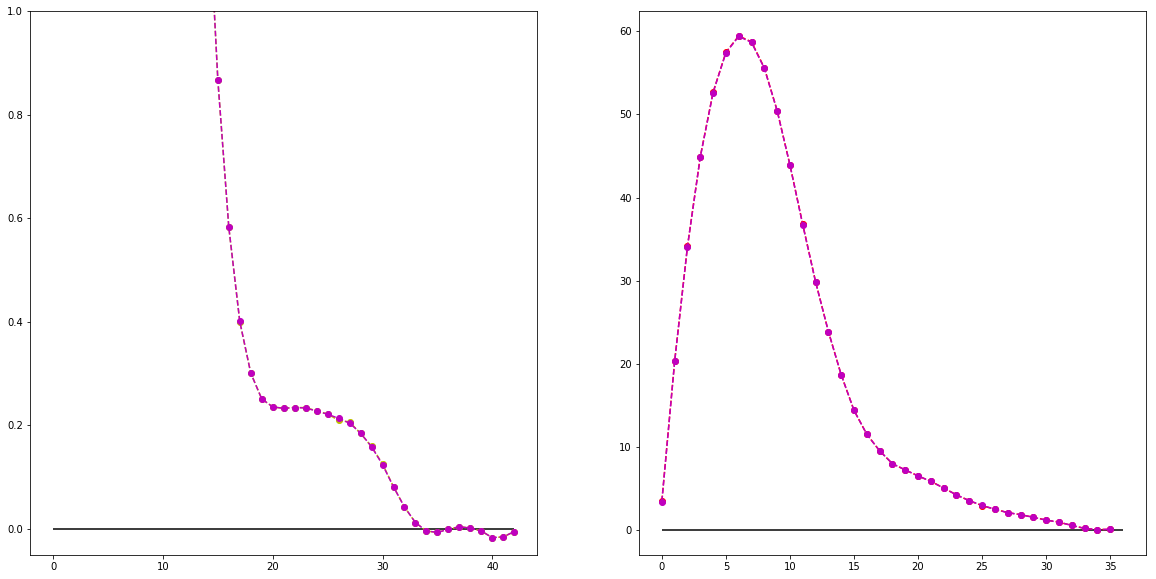

In [104]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,10))
axs[0].plot(np.array(b_all[1:1+len(pair_knots)])*(6*0.1**3) , 'yo--')
axs[0].plot(np.array(b_init[1:1+len(pair_knots)])*(6*0.1**3) , 'mo--')

axs[0].set_ylim(-0.05,1.0)
axs[0].hlines(0.0, 0, 42)
axs[1].plot(np.array(b_all[1+len(pair_knots):])*(6*0.1**3) , 'ro--')
axs[1].plot(np.array(b_init[1+len(pair_knots):])*(6*0.1**3) , 'mo--')
axs[1].hlines(0.0, 0, 36)

11
[-1139.189, 0.0, -1136.407, -1136.749, -1190.268, -1127.182]
[-1139.2, -0.0, -1136.401, -1136.751, -1190.261, -1127.175]


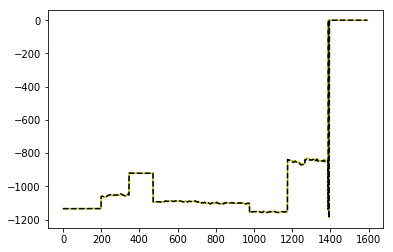

In [105]:
plt.plot(energy(b_all, X), 'y')
plt.plot(y[:,0], 'k--')
print(len(bounds))
#plt.xlim(1448,)
print([round(z, 3) for z in energy(b_all, X)[bounds[9]]])
print([round(z, 3) for z in y[bounds[9],0]])

In [106]:
stats_file = 'stats_bs_force_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpfx = pickle.load(fi, encoding='latin1')

stats_bsplinex = tpf_to_bsplines(stats_tpfx)

target_file = 'target_bs_force_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targetsx = pickle.load(fi, encoding='latin1')

len 50


In [107]:
stats_listx = [downselect(stats_bsplinex, pair_knots, edens_knots, bspline=True)]

for key in targets.keys():
    targetsx[key]['weight'] = 1.0
    
for i, stat in enumerate(stats_listx[-1:]):
    Xall, yall, weights, beta, dl, bounds, force_atoms = make_input_matrices_forces(targetsx, stat, keytrj=tkeys, combined=0.35, dl_dict=dl_dict)
    
    #Xall, yall, weights, beta, bounds = make_input_matrices(targetsx, stat, keytrj=tkeys)
    

lens forces 200 200 200 200
lens forces 146 146 146 146
lens forces 126 126 126 126
lens forces 236 236 236 236
lens forces 133 133 133 133
lens forces 136 136 136 136
lens forces 199 199 199 199
lens forces 91 91 91 91
lens forces 122 122 122 122
lens forces 21 21 21 21
lens forces 8 8 8 8
lens forces 8 8 8 8
lens forces 10 10 10 10
lens forces 12 12 12 12
lens forces 6 6 6 6
bounds [slice(0, 200, 1), slice(200, 346, 1), slice(346, 472, 1), slice(472, 708, 1), slice(708, 841, 1), slice(841, 977, 1), slice(977, 1176, 1), slice(1176, 1267, 1), slice(1267, 1389, 1), slice(1389, 1410, 1), slice(1410, 1418, 1), slice(1418, 1426, 1), slice(1426, 1436, 1), slice(1436, 1448, 1), slice(1448, 1454, 1), slice(0, 1654, 1)]


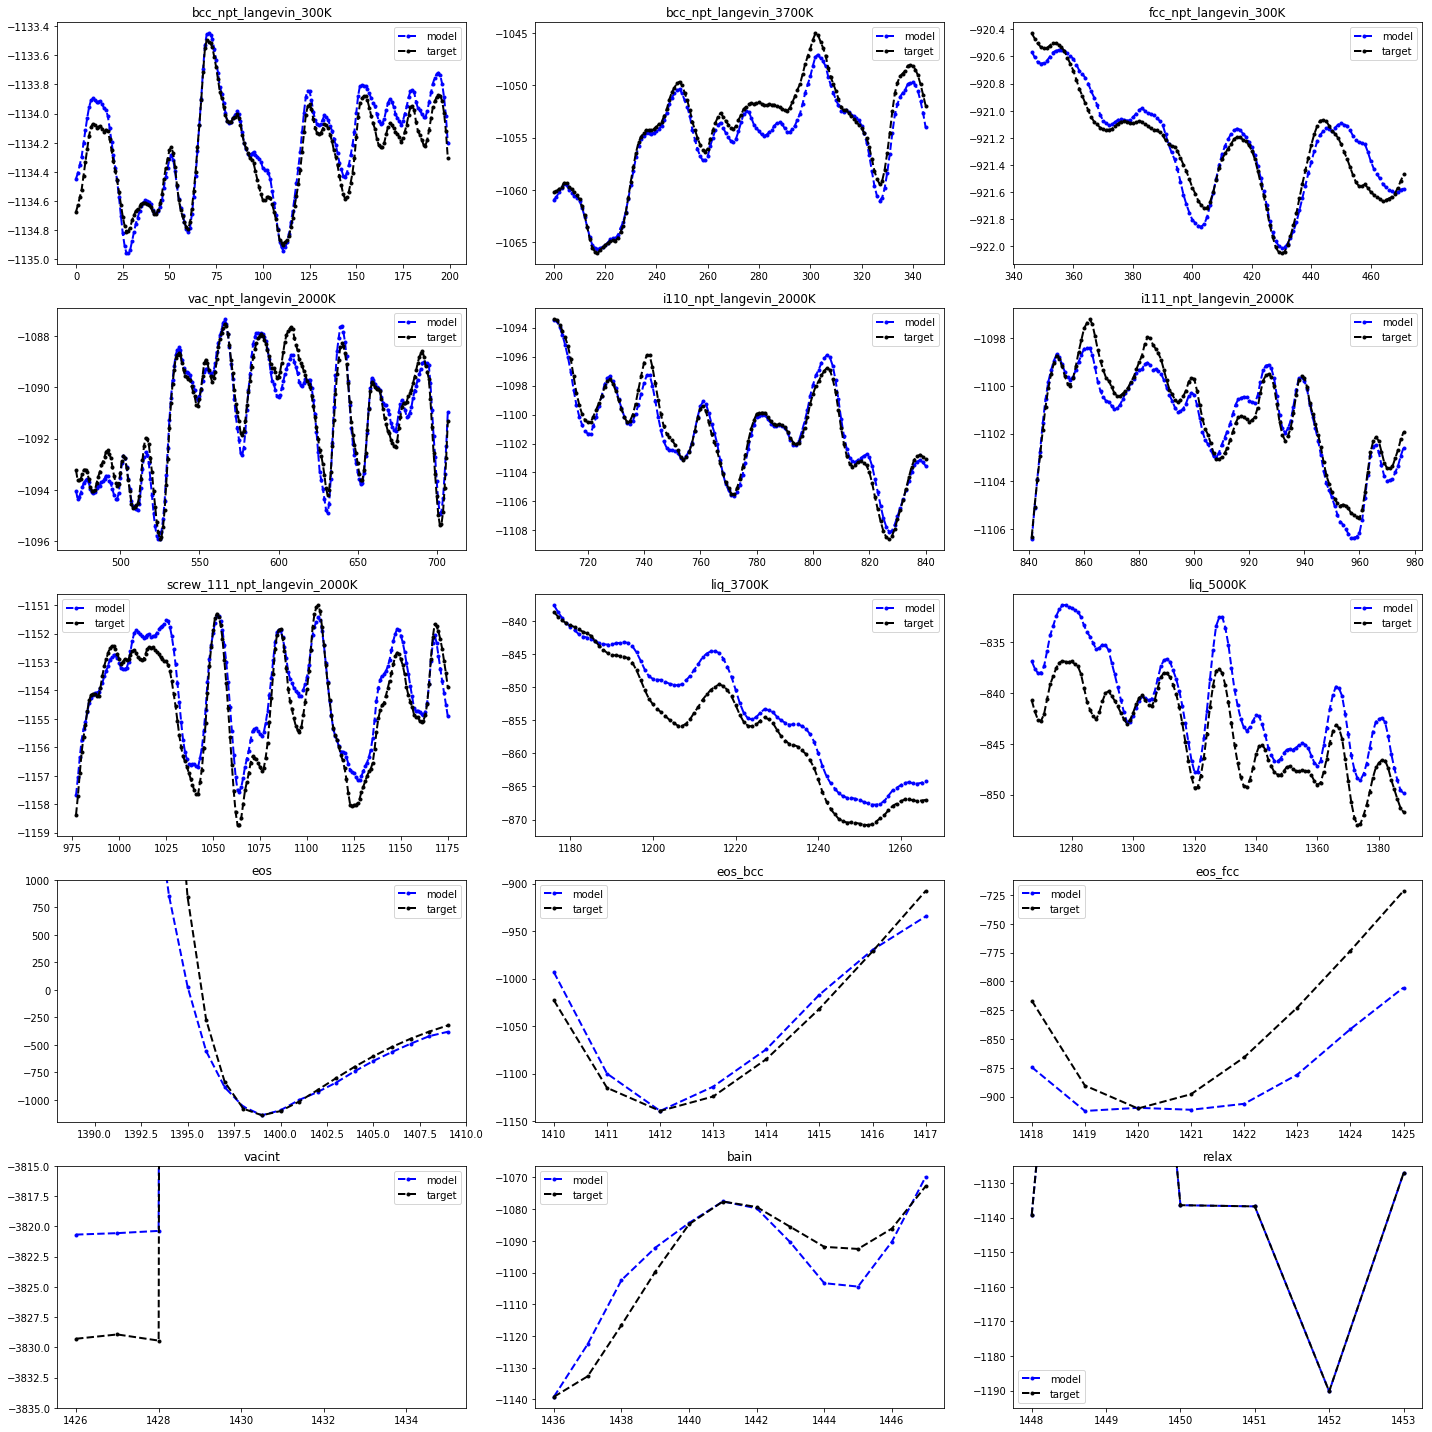

In [108]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,20))
    
for k, trj in enumerate(tkeys):
        
    i, j = divmod(k, 3)

    axes[i,j].set_title(trj)
        
    rr = list(range(len(Xall[0])))[bounds[k]][:]

    axes[i,j].plot(rr, energy(b_all, Xall)[bounds[k]][:], 'b.--', lw=2, label='model')

    axes[i,j].plot(rr, yall[bounds[k],0][:], 'k.--', lw=2, label='target')
    axes[i,j].legend()
    
    if trj == 'relax':
        axes[i,j].set_ylim(-1195, -1125)
        
    if trj == 'vacint':
        axes[i,j].set_ylim(-3835, -3815)
#        axes[i,j].set_xlim(1390,1392)
        
    if trj == 'eos':
        axes[i,j].set_ylim(-1200,1000)
        #axes[i,j].set_xlim(1395,)
    if trj == 'eos':
        axes[i,j].set_ylim(-1200,1000)
        #axes[i,j].set_xlim(1395,)
        
    #axes[i,j].set_xlim(*bounds[k][0])
    #axes[i,j].set_ylim(*bounds[k][1])

plt.tight_layout()

In [ ]:
p_knots = np.array(pair_knots)+0.4
print(p_knots)
e_knots = np.array(edens_knots)+0.4
print(e_knots)
n_edens = len(e_knots)

In [ ]:
def _bspline_coeffs_to_tpf(n_tot):
    """
    Finds b-spline coefficients reproducing a single cubic
    functin (rc-r)**3
    """

    penalty = [1.0, -4.0, 6.0, -4.0, 1.0]
    o = 4
    P = np.zeros((n_tot+4, n_tot), dtype=float)
    for i in range(n_tot+4):
        #ii = i - 4
        for j, p in enumerate(penalty):
            if i+j-o < 0 or i+j-o > n_tot-1:
                continue
            P[i, i+j-o] = p

    return P

In [ ]:
M = _bspline_coeffs_to_tpf(41)

In [ ]:
#b11_ext = np.array([4.2e3, 3.6e3, 3.10e3, 2.65e3] + list(b_weight11[2:]))*(6*0.1**3)
b11_ext = np.array(list(b_all[1:-n_edens]))#*(6*0.1**3)
print(b11_ext)
tpf_coeff = M.dot(b11_ext)
print(tpf_coeff)

In [ ]:
Medens = _bspline_coeffs_to_tpf(35)

In [ ]:
#b11_ext = np.array([4.2e3, 3.6e3, 3.10e3, 2.65e3] + list(b_weight11[2:]))*(6*0.1**3)
ed11_ext = np.array(list(b_all[-n_edens:]))#*(6*0.1**3)
print(ed11_ext)
edens_coeff = Medens.dot(ed11_ext)
print(edens_coeff)

In [ ]:
p_knot = [1.05, 1.15, 1.25, 1.35] + list(p_knots)
print(len(tpf_coeff), len(p_knot))
e_knot = [1.05, 1.15, 1.25, 1.35] + list(e_knots)
print(len(edens_coeff), len(e_knot))

In [ ]:
from statmechlib.forcefields import f_embed, f_dens, f_spline3

rr = np.linspace(1.3, 5.65, 436)

plt.plot(rr, [make_bspline(b_all[1:-n_edens], p_knot, r) for r in rr])
plt.xlim(1.3,)

#print(rr)
bs_target = [make_bspline(b_all[1:-n_edens], p_knot, r) for r in rr]
plt.plot(rr, [f_spline3(r, tpf_coeff, p_knot) for r in rr], 'r--')
plt.ylim(-0.3,1)
plt.xlim(rr[0], rr[-1])
plt.hlines(0.0, rr[0], rr[-1])
plt.savefig('pair_potential')

In [ ]:
from statmechlib.forcefields import f_embed, f_dens, f_spline3

rr = np.linspace(1.3, 5.65, 436)

plt.plot(rr, [make_bspline(b_all[-n_edens:], p_knot, r) for r in rr])
plt.xlim(1.3,)

#print(rr)
bs_target = [make_bspline(b_all[-n_edens:], e_knot, r) for r in rr]
plt.plot(rr, [f_spline3(r, edens_coeff, e_knot) for r in rr], 'r--')
plt.ylim(-10,50)
plt.xlim(4,5)
plt.xlim(rr[0], rr[-1])
plt.hlines(0.0, rr[0], rr[-1])
plt.savefig('pair_potential')

In [ ]:
tpf_coeff

In [ ]:
edens_coeff

In [ ]:
params = {
    'hyperparams':{'pair':[], 'edens':[]},
    'params':{'pair':[], 'edens':[]}}
params['hyperparams']['pair'] = p_knot
params['params']['pair'] = tpf_coeff
params['hyperparams']['edens'] = e_knot
params['params']['edens'] = edens_coeff
params['params']['embed'] = [-1.0, b_all[0]]

In [ ]:
param_list = [params]
#param_list

In [ ]:
file_name = os.path.join(working, "params_final_from_marica.pickle")

for params in param_list[-1:]:
    params_to_pickle(params, file_name)#, encoding='latin1', protocol=3)

In [ ]:
file_name = os.path.join(working, "params_final_from_marica.pickle")

with open(file_name, 'rb') as fi:
    params_store = pickle.load(fi)
#params_store[-1]

In [ ]:
print('pair')

for c, k in zip(tpf_coeff, p_knot):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))

print('edens') 
for c, k in zip(edens_coeff, e_knot):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))
        
print('embed')
print(-1.0, b_all[0])
#print(-4.42166597e-01,  1.12818607e-04)
#print(-4.49779872e-01,  1.09664665e-04)

In [ ]:
par = param_list[2]
print('pair')
for c, k in zip(par['params']['pair'], par['hyperparams']['pair']):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
print('edens')   
for c, k in zip(par['params']['edens'], par['hyperparams']['edens']):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
print('embed')    
par['params']['embed']